# Preprocesamiento de datos e ingeniería de caracteriticas

In [1]:
# Manejo de datos
import pandas as pd
import numpy as np
import random

# Preprocesamiento e imputación (habilita IterativeImputer experimental)
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)

# Reducción de dimensionalidad
from sklearn.decomposition import PCA

# Modelado y validación
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# Modelos y balanceo
import xgboost as xgb
from imblearn.over_sampling import SMOTENC

# Métricas y evaluación
from sklearn.metrics import (
    make_scorer,
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)

# Análisis estadístico y diagnóstico
from scipy.stats import spearmanr, chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance

# Interpretabilidad
import shap

# Visualización
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns


# Mostrar todas las columnas al imprimir DataFrames
pd.set_option('display.max_columns', None)

# Silenciar advertencias no críticas para mantener el output limpio
import warnings
warnings.filterwarnings("ignore")

A partir de los resultados de nuestro Análisis Exploratorio de Datos (EDA), identificamos varias características que tienen un impacto significativo en la deserción (churn), como el tipo de servicio de Internet, la antigüedad del cliente (Tenure) y otras.
Sin embargo, también existen variables que parecen estar correlacionadas, pero que en realidad pueden estar influenciadas por otros factores.
En esta sección, reexaminaremos todas las características y aplicaremos diversas técnicas de ingeniería de características y preprocesamiento antes de construir el modelo de aprendizaje automático.

In [2]:
# Cargar el archivo CSV con los datos originales
datos_telco = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Convertir la columna 'TotalCharges' a numérica y reemplazar valores no válidos por NaN
datos_telco['TotalCharges'] = pd.to_numeric(datos_telco['TotalCharges'], errors='coerce')

In [3]:
# Crear una tabla de contingencia entre las variables 'MultipleLines' y 'Churn'
tabla_frecuencias = pd.crosstab(datos_telco['MultipleLines'], datos_telco['Churn'])

# Mostrar la tabla resultante
tabla_frecuencias


Churn,No,Yes
MultipleLines,,
No,2541,849
No phone service,512,170
Yes,2121,850


In [4]:
# Mostrar información general del DataFrame
datos_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Filtrar los registros donde la columna 'TotalCharges' tiene valores faltantes
datos_telco[datos_telco['TotalCharges'].isna()]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Imputaremos los valores faltantes en TotalCharges con 0, ya que estos corresponden a clientes nuevos cuyos cargos totales aún no se han acumulado.

In [6]:
# Reemplazar los valores faltantes en 'TotalCharges' por cero
datos_telco['TotalCharges'] = datos_telco['TotalCharges'].fillna(0)

In [7]:
# Convertir la columna 'TotalCharges' a tipo numérico y forzar errores a NaN
datos_telco['TotalCharges'] = pd.to_numeric(datos_telco['TotalCharges'], errors='coerce')

# Identificar columnas categóricas y numéricas
columnas_categoricas = datos_telco.select_dtypes(include=['object']).columns.tolist()
columnas_numericas = datos_telco.select_dtypes(exclude=['object']).columns.tolist()

# Variable categórica que requiere codificación especial
columnas_codificadas = ['SeniorCitizen']

# Excluir columnas no deseadas del conjunto categórico
excluir_cat = ['customerID', 'Churn']
columnas_cat_final = [col for col in columnas_categoricas if col not in excluir_cat]

# Excluir columnas no deseadas del conjunto numérico
excluir_num = ['SeniorCitizen']
columnas_num_final = [col for col in columnas_numericas if col not in excluir_num]

# Mostrar los resultados
print("Columnas categóricas:", columnas_cat_final, '\n')
print("Columnas numéricas:", columnas_num_final, '\n')
print("Columnas categóricas codificadas:", columnas_codificadas, '\n')


Columnas categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'] 

Columnas numéricas: ['tenure', 'MonthlyCharges', 'TotalCharges'] 

Columnas categóricas codificadas: ['SeniorCitizen'] 



In [8]:
# Crear una copia del DataFrame original para trabajar sin modificar los datos base
datos_telco_copia = datos_telco.copy()

In [9]:
# Definir la variable objetivo
objetivo = 'Churn'

# Mapear la columna 'Churn' a valores numéricos: No → 0, Yes → 1
datos_telco_copia[objetivo] = datos_telco['Churn'].map({'No': 0, 'Yes': 1})


In [10]:
# Función para calcular la correlación de Spearman entre variables numéricas y la variable objetivo
def correlacion_spearman(df_datos, columnas_numericas, columna_objetivo):
    resultados = []
    for col in columnas_numericas:
        correlacion, _ = spearmanr(df_datos[col], df_datos[columna_objetivo])
        resultados.append({
            'Variable': col,
            'Correlacion_Spearman': correlacion,
            'Correlacion_Absoluta': abs(correlacion)
        })
    
    # Retornar un DataFrame ordenado de mayor a menor correlación absoluta
    return (
        pd.DataFrame(resultados)
        .sort_values(by='Correlacion_Absoluta', ascending=False)
        .reset_index(drop=True)
    )

# Calcular las correlaciones para las variables numéricas
correlaciones_numericas = correlacion_spearman(
    df_datos=datos_telco_copia,
    columnas_numericas=columnas_num_final,
    columna_objetivo=objetivo
)

# Mostrar los resultados
correlaciones_numericas


,Variable,Correlacion_Spearman,Correlacion_Absoluta
0,tenure,-0.367062,0.367062
1,TotalCharges,-0.229955,0.229955
2,MonthlyCharges,0.184743,0.184743


Para las variables numéricas, concluimos que la antigüedad (tenure) es la característica más correlacionada con la deserción (churn).
Sin embargo, durante el análisis exploratorio de datos (EDA), también encontramos que otras variables, como Total Charges y Monthly Charges, están correlacionadas con la antigüedad.
Para abordar este problema, podemos realizar una verificación de multicolinealidad utilizando el Factor de Inflación de la Varianza (VIF, por sus siglas en inglés).

In [11]:
# Conservar únicamente las columnas numéricas y asegurar que sean de tipo numérico
datos_telco_copia = datos_telco_copia[columnas_num_final].apply(pd.to_numeric, errors='coerce')

# Reemplazar valores infinitos por NaN y eliminar filas con valores faltantes
datos_telco_copia = datos_telco_copia.replace([np.inf, -np.inf], np.nan).dropna()

In [12]:
# Función para calcular el Factor de Inflación de la Varianza (VIF)
def calcular_vif(dataframe):
    tabla_vif = pd.DataFrame()
    tabla_vif["Variable"] = dataframe.columns
    tabla_vif["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    
    # Clasificar el nivel de colinealidad
    tabla_vif["Nivel"] = tabla_vif["VIF"].apply(
        lambda v: "Bajo" if v < 5 
        else "Medio" if v < 10 
        else "Alto"
    )
    
    # Retornar la tabla ordenada de mayor a menor VIF
    return (
        tabla_vif.sort_values(by='VIF', ascending=False)
                 .reset_index(drop=True)
    )

# Calcular los valores VIF para las variables numéricas seleccionadas
calcular_vif(datos_telco_copia)


,Variable,VIF,Nivel
0,TotalCharges,8.075070,Medio
1,tenure,6.332328,Medio
2,MonthlyCharges,3.355660,Bajo


A partir de los resultados del VIF, podemos observar que Total Charges y Tenure presentan un nivel moderado de multicolinealidad, mientras que Monthly Charges muestra un nivel relativamente bajo. Un nivel moderado indica que existe cierta correlación entre estas variables, lo cual debe tenerse en cuenta al construir el modelo de aprendizaje automático. Considerar este factor nos permite desarrollar un modelo más eficiente y robusto.

En la etapa de modelado, compararemos los resultados de evaluación entre usar todas las variables y usar un conjunto reducido de variables, ya sea eliminando una de las más colineales o aplicando una técnica de reducción de dimensionalidad (PCA).

Desde una perspectiva matemática, Total Charges puede derivarse esencialmente de la multiplicación entre Tenure y Monthly Charges, ajustada por posibles descuentos. Por lo tanto, podemos eliminar Total Charges, ya que su información ya está representada por las otras dos variables.

In [13]:
# Crear una lista de variables numéricas excluyendo 'TotalCharges'
columnas_num_sin_total = [col for col in columnas_num_final if col != 'TotalCharges']

# Calcular el VIF solo para las variables seleccionadas
calcular_vif(datos_telco_copia[columnas_num_sin_total])


,Variable,VIF,Nivel
0,tenure,2.612607,Bajo
1,MonthlyCharges,2.612607,Bajo


Después de eliminar la columna Total Charges, podemos observar que el nivel de multicolinealidad se ha reducido significativamente.

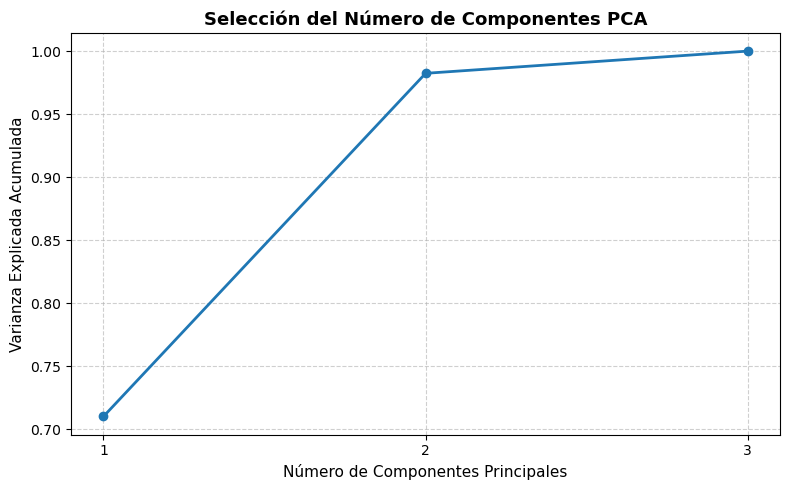

In [14]:
# Seleccionar las columnas numéricas
datos_numericos = datos_telco_copia[columnas_num_final]

# Escalar los datos con MinMaxScaler
escalador = MinMaxScaler()
datos_escalados = escalador.fit_transform(datos_numericos)

# Aplicar PCA sin limitar el número de componentes
modelo_pca = PCA()
modelo_pca.fit(datos_escalados)

# Calcular la varianza explicada y su acumulado
varianza_explicada = modelo_pca.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

# Visualizar la varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(varianza_explicada) + 1), varianza_acumulada, 
         marker='o', linestyle='-', linewidth=2, markersize=6)
plt.xticks(range(1, len(varianza_explicada) + 1))
plt.xlabel("Número de Componentes Principales", fontsize=11)
plt.ylabel("Varianza Explicada Acumulada", fontsize=11)
plt.title("Selección del Número de Componentes PCA", fontsize=13, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [15]:
# Definir el número de componentes principales a analizar
n_componentes = 2

# Obtener la varianza acumulada hasta ese componente
varianza_acumulada_n = varianza_acumulada[n_componentes - 1]

# Mostrar el resultado formateado
print(f"Varianza acumulada con {n_componentes} componentes: {varianza_acumulada_n:.2f}")


Varianza acumulada con 2 componentes: 0.98


A partir de los resultados del PCA, podemos observar que con solo dos dimensiones ya es posible representar casi toda la información de los datos numéricos, explicando aproximadamente el 98 % de la varianza.

In [16]:
# Aplicar PCA seleccionando dos componentes principales
modelo_pca_2 = PCA(n_components=2)
datos_pca = modelo_pca_2.fit_transform(datos_escalados)

# Crear un DataFrame con los resultados del PCA
df_componentes_pca = pd.DataFrame(
    datos_pca,
    columns=['Componente_1', 'Componente_2']
)

# Mostrar las dos primeras filas del DataFrame
df_componentes_pca.head(2)


,Componente_1,Componente_2
0,-0.602448,-0.049168
1,-0.044975,-0.078521


In [17]:
# Calcular el VIF (Factor de Inflación de la Varianza) sobre los componentes principales del PCA
calcular_vif(df_componentes_pca)

,Variable,VIF,Nivel
0,Componente_1,1.0,Bajo
1,Componente_2,1.0,Bajo


Recomendaría aplicar el Análisis de Componentes Principales (PCA) en lugar de eliminar la variable TotalCharges. La razón es que el PCA permite conservar la información de las tres variables (tenure, MonthlyCharges y TotalCharges) transformándolas en nuevos componentes principales. Aunque la interpretabilidad de estos componentes es menos intuitiva en comparación con simplemente descartar una variable, el PCA es estadísticamente más robusto, ya que mitiga la multicolinealidad sin sacrificar la información subyacente contenida en las variables originales.

In [18]:
# Función para calcular el coeficiente V de Cramér entre dos variables categóricas
def cramers_v(var1, var2):
    # Crear la tabla de contingencia
    tabla_contingencia = pd.crosstab(var1, var2)
    
    # Calcular el estadístico chi-cuadrado
    chi2 = chi2_contingency(tabla_contingencia)[0]
    
    # Calcular el número total de observaciones
    n = tabla_contingencia.to_numpy().sum()
    
    # Calcular la dimensión mínima (ajuste de corrección)
    min_dim = min(tabla_contingencia.shape) - 1
    
    # Calcular el valor de Cramér V
    v_cramer = np.sqrt(chi2 / (n * min_dim))
    return v_cramer


# Función para calcular el V de Cramér entre las variables categóricas y la variable objetivo
def correlacion_categorica(df_datos, columnas_categoricas, columna_objetivo):
    resultados = []
    for col in columnas_categoricas:
        v = cramers_v(df_datos[col], df_datos[columna_objetivo])
        resultados.append({'Variable': col, 'Cramers_V': v})
    
    # Retornar un DataFrame ordenado por correlación descendente
    return (
        pd.DataFrame(resultados)
        .sort_values('Cramers_V', ascending=False)
        .reset_index(drop=True)
    )

# Calcular las correlaciones categóricas respecto a la variable objetivo
correlaciones_categoricas = correlacion_categorica(datos_telco, columnas_cat_final, objetivo)

# Mostrar resultados
correlaciones_categoricas


,Variable,Cramers_V
0,Contract,0.410116
1,OnlineSecurity,0.347400
2,TechSupport,0.342916
3,InternetService,0.322455
4,PaymentMethod,0.303359
5,OnlineBackup,0.292316
6,DeviceProtection,0.281580
7,StreamingMovies,0.230951
8,StreamingTV,0.230502
9,PaperlessBilling,0.191498


In [19]:
# Calcular el coeficiente de Cramér V para las variables categóricas codificadas
correlaciones_codificadas = correlacion_categorica(
    datos_telco,
    columnas_codificadas,
    objetivo
)

# Mostrar los resultados
correlaciones_codificadas


,Variable,Cramers_V
0,SeniorCitizen,0.150453


Ahora combinaremos todos los resultados de correlación anteriores en un nuevo DataFrame para identificar qué variables presentan las correlaciones más altas.

In [20]:
# Renombrar las columnas de correlación para unificarlas
df_corr_num = correlaciones_numericas.rename(columns={"Correlacion_Absoluta": "Correlacion"})[["Variable", "Correlacion"]]
df_corr_cat = correlaciones_categoricas.rename(columns={"Cramers_V": "Correlacion"})[["Variable", "Correlacion"]]
df_corr_cod = correlaciones_codificadas.rename(columns={"Cramers_V": "Correlacion"})[["Variable", "Correlacion"]]

# Combinar todas las correlaciones en un solo DataFrame
df_correlaciones_total = pd.concat([df_corr_num, df_corr_cat, df_corr_cod], ignore_index=True)

# Ordenar las variables por mayor nivel de correlación
df_correlaciones_total = (
    df_correlaciones_total.sort_values(by='Correlacion', ascending=False)
                          .reset_index(drop=True)
)

# Mostrar el resultado final
df_correlaciones_total


,Variable,Correlacion
0,Contract,0.410116
1,tenure,0.367062
2,OnlineSecurity,0.347400
3,TechSupport,0.342916
4,InternetService,0.322455
5,PaymentMethod,0.303359
6,OnlineBackup,0.292316
7,DeviceProtection,0.281580
8,StreamingMovies,0.230951
9,StreamingTV,0.230502


Las cinco variables más fuertemente asociadas con la deserción (churn) son Contract, Tenure, Online Security, Tech Support e Internet Service. Entre ellas, Contract presenta la correlación más alta con churn, lo que indica que el tipo de contrato desempeña un papel fundamental en la retención de clientes. Tenure resalta la importancia del ciclo de vida del cliente, mientras que los servicios de valor agregado como Online Security y Tech Support contribuyen adicionalmente a reducir el riesgo de deserción. Por su parte, el tipo de Internet Service también se perfila como un factor clave que influye en el comportamiento del cliente.

A continuación, nos centraremos en las variables con una fuerza de correlación superior a 0.15. Se establece este umbral porque algunas variables, como Senior Citizen, Dependents y Partner, pueden ejercer una influencia significativa sobre la deserción, incluso si sus correlaciones son relativamente pequeñas.

In [21]:
# Mostrar las 10 variables numéricas con mayor correlación absoluta respecto a la variable objetivo
correlaciones_numericas.sort_values("Correlacion_Absoluta", ascending=False).head(10)

,Variable,Correlacion_Spearman,Correlacion_Absoluta
0,tenure,-0.367062,0.367062
1,TotalCharges,-0.229955,0.229955
2,MonthlyCharges,0.184743,0.184743


In [22]:
# Seleccionar variables numéricas con correlación absoluta mayor a 0.15
variables_numericas_sel = correlaciones_numericas[
    correlaciones_numericas["Correlacion_Absoluta"] > 0.15
]["Variable"].tolist()

# Seleccionar variables categóricas con valor de Cramér V mayor a 0.15
variables_categoricas_sel = correlaciones_categoricas[
    correlaciones_categoricas["Cramers_V"] > 0.15
]["Variable"].tolist()

# Incluir las variables categóricas codificadas
variables_categ_cod_sel = correlaciones_codificadas["Variable"].tolist()


In [23]:
# Combinar todas las variables seleccionadas (numéricas, categóricas y categóricas codificadas)
todas_las_variables = (
    variables_numericas_sel +
    variables_categoricas_sel +
    variables_categ_cod_sel
)

# Mostrar la lista final de variables seleccionadas
todas_las_variables


['tenure',
 'TotalCharges',
 'MonthlyCharges',
 'Contract',
 'OnlineSecurity',
 'TechSupport',
 'InternetService',
 'PaymentMethod',
 'OnlineBackup',
 'DeviceProtection',
 'StreamingMovies',
 'StreamingTV',
 'PaperlessBilling',
 'Dependents',
 'Partner',
 'SeniorCitizen']

In [24]:
# Convertir la variable objetivo 'Churn' a valores numéricos (No → 0, Yes → 1)
datos_telco['Churn'] = datos_telco['Churn'].map({'No': 0, 'Yes': 1}).astype('int8')

In [25]:
# Definir las variables predictoras (X) y la variable objetivo (y)
X = datos_telco[todas_las_variables]
y = datos_telco['Churn']

# Dividir los datos en conjuntos de entrenamiento y prueba (80% - 20%)
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

A continuación, crearemos dos preprocesadores: uno que incluya PCA y otro que no lo utilice.

Este enfoque nos permitirá evaluar si el PCA reduce la multicolinealidad y analizar su impacto en las métricas de desempeño, como la precisión (accuracy) y la sensibilidad (recall).

In [26]:
# Pipeline para variables numéricas: imputación iterativa + normalización
pipeline_numerico = Pipeline([
    ('imputador', IterativeImputer(random_state=0, min_value=0)),
    ('escalador', MinMaxScaler())
])

# Pipeline para variables categóricas: imputación del valor más frecuente + codificación one-hot
pipeline_categorico = Pipeline([
    ('imputador', SimpleImputer(strategy='most_frequent')),
    ('codificador', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para variables categóricas codificadas (solo imputación)
pipeline_categ_cod = Pipeline([
    ('imputador', SimpleImputer(strategy='most_frequent'))
])

# Combinación de todos los pipelines en un preprocesador general
preprocesador_1 = ColumnTransformer([
    ('numerico', pipeline_numerico, variables_numericas_sel),
    ('categorico', pipeline_categorico, variables_categoricas_sel),
    ('categorico_cod', pipeline_categ_cod, variables_categ_cod_sel)
], verbose=True)

# Aplicar el preprocesamiento a los conjuntos de entrenamiento y prueba
X_entrenamiento_proc_1 = preprocesador_1.fit_transform(X_entrenamiento)
X_prueba_proc_1 = preprocesador_1.transform(X_prueba)


[ColumnTransformer] ...... (1 of 3) Processing numerico, total=   0.0s
[ColumnTransformer] .... (2 of 3) Processing categorico, total=   0.0s
[ColumnTransformer]  (3 of 3) Processing categorico_cod, total=   0.0s


In [27]:
# Obtener los nombres de las columnas numéricas
columnas_numericas_finales = variables_numericas_sel

# Obtener los nombres de las columnas generadas por el OneHotEncoder
columnas_categoricas_finales = preprocesador_1.named_transformers_['categorico']['codificador']\
    .get_feature_names_out(variables_categoricas_sel)

# Obtener las columnas categóricas codificadas (que no se transformaron con OneHotEncoder)
columnas_codificadas_finales = variables_categ_cod_sel

# Combinar todas las columnas procesadas en una sola lista
todas_las_columnas_1 = list(columnas_numericas_finales) + \
                       list(columnas_categoricas_finales) + \
                       list(columnas_codificadas_finales)

# Crear DataFrames a partir de los datos procesados
X_entrenamiento_df = pd.DataFrame(X_entrenamiento_proc_1, columns=todas_las_columnas_1)
X_prueba_df = pd.DataFrame(X_prueba_proc_1, columns=todas_las_columnas_1)

# Mostrar dimensiones y vista previa
print('Dimensiones del conjunto de entrenamiento:', X_entrenamiento_df.shape)
X_entrenamiento_df.head()


Dimensiones del conjunto de entrenamiento: (5634, 38)


,tenure,TotalCharges,MonthlyCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,PaperlessBilling_No,PaperlessBilling_Yes,Dependents_No,Dependents_Yes,Partner_No,Partner_Yes,SeniorCitizen
0,0.486111,0.195934,0.306926,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.208333,0.132594,0.565022,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.180556,0.067975,0.220727,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.361111,0.219429,0.549078,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,0.013889,0.005130,0.260588,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [28]:
# Pipeline numérico con PCA incluido: imputación, escalado y reducción de dimensionalidad
pipeline_numerico_pca = Pipeline([
    ('imputador', IterativeImputer(random_state=0, min_value=0)),
    ('escalador', MinMaxScaler()),
    ('pca', PCA(n_components=2, random_state=0))
])

# Crear un preprocesador que combine los tres tipos de variables
preprocesador_2 = ColumnTransformer([
    ('numerico', pipeline_numerico_pca, variables_numericas_sel),
    ('categorico', pipeline_categorico, variables_categoricas_sel),
    ('categorico_cod', pipeline_categ_cod, variables_categ_cod_sel)
], verbose=True)

# Aplicar el preprocesamiento con PCA a los conjuntos de entrenamiento y prueba
X_entrenamiento_proc_2 = preprocesador_2.fit_transform(X_entrenamiento)
X_prueba_proc_2 = preprocesador_2.transform(X_prueba)


[ColumnTransformer] ...... (1 of 3) Processing numerico, total=   0.0s
[ColumnTransformer] .... (2 of 3) Processing categorico, total=   0.0s
[ColumnTransformer]  (3 of 3) Processing categorico_cod, total=   0.0s


In [29]:
# Asignar nombres a los dos componentes principales del PCA
columnas_pca = [f'Componente_PCA_{i+1}' for i in range(2)]

# Obtener los nombres de las columnas creadas por el OneHotEncoder
columnas_categoricas_finales = preprocesador_2.named_transformers_['categorico']['codificador']\
    .get_feature_names_out(variables_categoricas_sel)

# Obtener las columnas categóricas codificadas (sin transformación)
columnas_codificadas_finales = variables_categ_cod_sel

# Combinar todas las columnas resultantes
todas_las_columnas_2 = list(columnas_pca) + \
                       list(columnas_categoricas_finales) + \
                       list(columnas_codificadas_finales)

# Crear DataFrames con los datos procesados (incluyendo PCA)
X_entrenamiento_df = pd.DataFrame(X_entrenamiento_proc_2, columns=todas_las_columnas_2)
X_prueba_df = pd.DataFrame(X_prueba_proc_2, columns=todas_las_columnas_2)

# Mostrar forma y primeras filas
print('Dimensiones del conjunto de entrenamiento:', X_entrenamiento_df.shape)
X_entrenamiento_df.head()


Dimensiones del conjunto de entrenamiento: (5634, 37)


,Componente_PCA_1,Componente_PCA_2,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,PaperlessBilling_No,PaperlessBilling_Yes,Dependents_No,Dependents_Yes,Partner_No,Partner_Yes,SeniorCitizen
0,-0.086203,-0.150992,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-0.196561,0.216978,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.407200,-0.052447,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.049333,0.119910,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,-0.539322,0.072966,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


Next, we will apply resampling techniques to handle data imbalance. Besides resampling, we can also adjust the decision threshold to further improve the model’s performance.

In the following code example, we will use SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous features), which is specifically designed for datasets that contain both categorical and continuous variables. This method generates synthetic samples for the minority class while preserving the relationships between categorical and numerical features.

In [30]:
# Identificar los índices de las variables categóricas en el conjunto procesado (sin PCA)
indices_categoricos_1 = list(
    range(len(variables_numericas_sel), X_entrenamiento_proc_1.shape[1])
)

# Aplicar sobremuestreo SMOTENC para balancear la clase minoritaria
smote_nc = SMOTENC(
    categorical_features=indices_categoricos_1,
    sampling_strategy='minority',
    random_state=42
)

# Generar el nuevo conjunto de entrenamiento balanceado (sin PCA)
X_entrenamiento_res_1, y_entrenamiento_res_1 = smote_nc.fit_resample(
    X_entrenamiento_proc_1, y_entrenamiento
)

In [31]:
# Definir los índices de las variables categóricas en el conjunto procesado con PCA
# (Las dos primeras columnas corresponden a los componentes principales)
indices_categoricos_2 = list(range(2, X_entrenamiento_proc_2.shape[1]))

# Aplicar sobremuestreo SMOTENC para balancear la clase minoritaria
smote_nc = SMOTENC(
    categorical_features=indices_categoricos_2,
    sampling_strategy='minority',
    random_state=42
)

# Ajustar y generar el nuevo conjunto de entrenamiento balanceado (con PCA)
X_entrenamiento_res_2, y_entrenamiento_res_2 = smote_nc.fit_resample(
    X_entrenamiento_proc_2, y_entrenamiento
)


In [32]:
# Resumen del balanceo de clases (conjunto sin PCA)
print('Ingeniería de características sin PCA\n')

print("Distribución original de clases:")
for clase in set(y_entrenamiento):
    cantidad = list(y_entrenamiento).count(clase)
    print(f"Clase {clase}: {cantidad} registros")

print("\nDistribución de clases después del sobremuestreo (SMOTENC):")
for clase in set(y_entrenamiento_res_1):
    cantidad = list(y_entrenamiento_res_1).count(clase)
    print(f"Clase {clase}: {cantidad} registros")


Ingeniería de características sin PCA

Distribución original de clases:
Clase 0: 4139 registros
Clase 1: 1495 registros

Distribución de clases después del sobremuestreo (SMOTENC):
Clase 0: 4139 registros
Clase 1: 4139 registros


In [33]:
# Resumen del balanceo de clases (conjunto con PCA)
print('Ingeniería de características con PCA\n')

print("Distribución original de clases:")
for clase in set(y_entrenamiento):
    cantidad = list(y_entrenamiento).count(clase)
    print(f"Clase {clase}: {cantidad} registros")

print("\nDistribución de clases después del sobremuestreo (SMOTENC):")
for clase in set(y_entrenamiento_res_2):
    cantidad = list(y_entrenamiento_res_2).count(clase)
    print(f"Clase {clase}: {cantidad} registros")


Ingeniería de características con PCA

Distribución original de clases:
Clase 0: 4139 registros
Clase 1: 1495 registros

Distribución de clases después del sobremuestreo (SMOTENC):
Clase 0: 4139 registros
Clase 1: 4139 registros


In [34]:
# Crear un DataFrame con los datos balanceados (sin PCA) y sus nombres de columnas
X_resampleado_1 = pd.DataFrame(X_entrenamiento_res_1, columns=todas_las_columnas_1)

# Mostrar las primeras filas del conjunto re-muestreado
X_resampleado_1.head()

,tenure,TotalCharges,MonthlyCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,PaperlessBilling_No,PaperlessBilling_Yes,Dependents_No,Dependents_Yes,Partner_No,Partner_Yes,SeniorCitizen
0,0.486111,0.195934,0.306926,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.208333,0.132594,0.565022,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.180556,0.067975,0.220727,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.361111,0.219429,0.549078,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,0.013889,0.005130,0.260588,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [35]:
# Crear un DataFrame con los datos balanceados (con PCA) y sus nombres de columnas
X_resampleado_2 = pd.DataFrame(X_entrenamiento_res_2, columns=todas_las_columnas_2)

# Mostrar las primeras filas del conjunto re-muestreado
X_resampleado_2.head()

,Componente_PCA_1,Componente_PCA_2,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,PaperlessBilling_No,PaperlessBilling_Yes,Dependents_No,Dependents_Yes,Partner_No,Partner_Yes,SeniorCitizen
0,-0.086203,-0.150992,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-0.196561,0.216978,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.407200,-0.052447,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.049333,0.119910,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,-0.539322,0.072966,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


# Selección del modelo

In [36]:
# === COMPARACIÓN SIN CV + RUNNER DE ESCENARIOS (sustituye tu celda In[28]) ===
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  # reemplazo de GradientBoosting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time, pandas as pd, numpy as np
import xgboost as xgb

# -------------------------
# 1) Función comparar_modelos
# -------------------------
def comparar_modelos(Xtr, Xte, ytr, yte, nombre_banco="no_pca"):
    """
    Compara cuatro modelos: DecisionTree, RandomForest, HistGradientBoosting y XGBoost.
    Usa las matrices ya procesadas que tienes en el notebook. SIN validación cruzada.
    """
    modelos = {
        "DecisionTree": DecisionTreeClassifier(random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
        "XGBoost": xgb.XGBClassifier(random_state=42)
    }

    filas = []
    for nombre, clf in modelos.items():
        # fit
        t0 = time.time()
        clf.fit(Xtr, ytr)
        fit_t = time.time() - t0

        # predict
        t1 = time.time()
        ypred = clf.predict(Xte)
        pred_t = time.time() - t1

        # probas para ROC-AUC
        try:
            proba = clf.predict_proba(Xte)[:, 1]
        except Exception:
            try:
                proba = clf.decision_function(Xte)
                proba = (proba - proba.min()) / (proba.max() - proba.min() + 1e-9)
            except Exception:
                proba = np.zeros(len(ypred))

        filas.append({
            "banco": nombre_banco,
            "modelo": nombre,
            "accuracy": accuracy_score(yte, ypred),
            "precision": precision_score(yte, ypred, zero_division=0),
            "recall": recall_score(yte, ypred, zero_division=0),
            "f1": f1_score(yte, ypred, zero_division=0),
            "roc_auc": roc_auc_score(yte, proba) if len(np.unique(yte)) == 2 else np.nan,
            "fit_s": round(fit_t, 3),
            "pred_s": round(pred_t, 3)
        })

    df_res = (pd.DataFrame(filas)
                .sort_values(["f1","roc_auc"], ascending=False)
                .reset_index(drop=True))
    return df_res

# -------------------------
# 2) Runner de escenarios (usa tus variables ya creadas en celdas anteriores)
# -------------------------
def correr_escenarios_sin_cv():
    escenarios = {}

    # ya las creaste en tu pipeline sin PCA
    if all(k in globals() for k in ["X_entrenamiento_proc_1","X_prueba_proc_1","y_entrenamiento","y_prueba"]):
        escenarios["no_pca"] = (X_entrenamiento_proc_1, X_prueba_proc_1, y_entrenamiento, y_prueba)

    # pipeline con PCA
    if all(k in globals() for k in ["X_entrenamiento_proc_2","X_prueba_proc_2","y_entrenamiento","y_prueba"]):
        escenarios["pca"] = (X_entrenamiento_proc_2, X_prueba_proc_2, y_entrenamiento, y_prueba)

    # SMOTENC sin PCA
    if all(k in globals() for k in ["X_entrenamiento_res_1","X_prueba_proc_1","y_entrenamiento_res_1","y_prueba"]):
        escenarios["no_pca_smote"] = (X_entrenamiento_res_1, X_prueba_proc_1, y_entrenamiento_res_1, y_prueba)

    # SMOTENC con PCA
    if all(k in globals() for k in ["X_entrenamiento_res_2","X_prueba_proc_2","y_entrenamiento_res_2","y_prueba"]):
        escenarios["pca_smote"] = (X_entrenamiento_res_2, X_prueba_proc_2, y_entrenamiento_res_2, y_prueba)

    if not escenarios:
        print("❌ No hay escenarios disponibles. Ejecuta primero las celdas que crean X_/y_.")
        return None, None, None

    tablas = []
    for banco, (Xtr, Xte, ytr, yte) in escenarios.items():
        try:
            dfb = comparar_modelos(Xtr, Xte, ytr, yte, nombre_banco=banco)
            tablas.append(dfb)
        except Exception as e:
            print(f"❌ Falló el escenario '{banco}': {e}")

    if not tablas:
        print("❌ No se generaron resultados.")
        return None, None, None

    res = pd.concat(tablas, axis=0, ignore_index=True)
    res = res.sort_values(["banco","f1","roc_auc"], ascending=[True, False, False])

    # Mejor por banco
    mejor_por_banco = (res.sort_values(["banco","f1","roc_auc"], ascending=[True, False, False])
                         .groupby("banco").head(1).reset_index(drop=True))

    # Top global
    top_global = res.sort_values(["f1","roc_auc"], ascending=False).head(10).reset_index(drop=True)

    print("\n=== Resultados por escenario ===")
    print(res)

    print("\n=== Mejor modelo por escenario ===")
    print(mejor_por_banco)

    print("\n=== Top global (todos los escenarios) ===")
    print(top_global)

    return res, mejor_por_banco, top_global

# -------------------------
# 3) ¡Ejecutar!
# -------------------------
res_all, best_by_bank, top_all = correr_escenarios_sin_cv()



=== Resultados por escenario ===
           banco        modelo  accuracy  precision    recall        f1  \
0         no_pca       XGBoost  0.773598   0.584098  0.510695  0.544936   
1         no_pca  RandomForest  0.775727   0.593548  0.491979  0.538012   
2         no_pca  DecisionTree  0.733854   0.498695  0.510695  0.504624   
6   no_pca_smote       XGBoost  0.757275   0.535088  0.652406  0.587952   
7   no_pca_smote  RandomForest  0.762243   0.547677  0.598930  0.572158   
8   no_pca_smote  DecisionTree  0.715401   0.471338  0.593583  0.525444   
3            pca       XGBoost  0.776437   0.595469  0.491979  0.538799   
4            pca  RandomForest  0.776437   0.596721  0.486631  0.536082   
5            pca  DecisionTree  0.721789   0.476190  0.481283  0.478723   
9      pca_smote       XGBoost  0.757984   0.533605  0.700535  0.605780   
10     pca_smote  RandomForest  0.763662   0.550369  0.598930  0.573624   
11     pca_smote  DecisionTree  0.721789   0.480769  0.601604  0.5

# Modelamiento

A continuación, construiremos un modelo de aprendizaje automático utilizando el algoritmo XGBoost. La razón para elegir XGBoost es que es uno de los marcos más potentes y eficientes disponibles en la actualidad. XGBoost está altamente optimizado tanto en velocidad como en rendimiento, lo que lo hace adecuado para manejar conjuntos de datos grandes y tareas complejas.

In [37]:
# Función para entrenar un clasificador XGBoost con early stopping
def clasificador_xgboost(X_entrenamiento, X_prueba, y_entrenamiento, y_prueba):
    # Configurar el criterio de parada temprana
    early_stopping = xgb.callback.EarlyStopping(
        rounds=5,              # Número de iteraciones sin mejora antes de detenerse
        metric_name='logloss', # Métrica monitoreada (logloss es común para clasificación binaria)
        save_best=True         # Guardar el mejor modelo durante el entrenamiento
    )

    # Inicializar el modelo XGBoost para clasificación binaria
    modelo_xgb = xgb.XGBClassifier(
        objective='binary:logistic',  # Tipo de problema: clasificación binaria
        learning_rate=0.3,            # Tasa de aprendizaje
        n_estimators=300,             # Número máximo de árboles
        random_state=42,              # Semilla para reproducibilidad
        eval_metric="logloss",        # Métrica de evaluación
        callbacks=[early_stopping]    # Incluir early stopping
    )

    # Conjuntos de evaluación (entrenamiento y prueba)
    conjuntos_eval = [(X_entrenamiento, y_entrenamiento),
                      (X_prueba, y_prueba)]

    # Entrenar el modelo con early stopping
    resultados_eval = {}
    modelo_xgb.fit(
        X_entrenamiento, y_entrenamiento,
        eval_set=conjuntos_eval,
        verbose=True
    )

    return modelo_xgb, modelo_xgb.evals_result()


In [38]:
# Entrenar el modelo XGBoost (sin PCA) y obtener los resultados de evaluación
modelo_xgb_1, resultados_eval_1 = clasificador_xgboost(
    X_entrenamiento_proc_1,
    X_prueba_proc_1,
    y_entrenamiento,
    y_prueba
)

[0]	validation_0-logloss:0.49304	validation_1-logloss:0.50335
[1]	validation_0-logloss:0.44970	validation_1-logloss:0.47028
[2]	validation_0-logloss:0.42211	validation_1-logloss:0.45214
[3]	validation_0-logloss:0.40162	validation_1-logloss:0.44102
[4]	validation_0-logloss:0.38788	validation_1-logloss:0.43271
[5]	validation_0-logloss:0.37727	validation_1-logloss:0.42851
[6]	validation_0-logloss:0.36919	validation_1-logloss:0.42679
[7]	validation_0-logloss:0.36288	validation_1-logloss:0.42691
[8]	validation_0-logloss:0.35858	validation_1-logloss:0.42689
[9]	validation_0-logloss:0.35347	validation_1-logloss:0.42605
[10]	validation_0-logloss:0.34871	validation_1-logloss:0.42348
[11]	validation_0-logloss:0.34620	validation_1-logloss:0.42499
[12]	validation_0-logloss:0.34211	validation_1-logloss:0.42519
[13]	validation_0-logloss:0.33920	validation_1-logloss:0.42530
[14]	validation_0-logloss:0.33777	validation_1-logloss:0.42613


In [39]:
# Entrenar el modelo XGBoost (con PCA) y obtener los resultados de evaluación
modelo_xgb_2, resultados_eval_2 = clasificador_xgboost(
    X_entrenamiento_proc_2,
    X_prueba_proc_2,
    y_entrenamiento,
    y_prueba
)

[0]	validation_0-logloss:0.49440	validation_1-logloss:0.50194
[1]	validation_0-logloss:0.45235	validation_1-logloss:0.46813
[2]	validation_0-logloss:0.42453	validation_1-logloss:0.44570
[3]	validation_0-logloss:0.40600	validation_1-logloss:0.43431
[4]	validation_0-logloss:0.39272	validation_1-logloss:0.42820
[5]	validation_0-logloss:0.38293	validation_1-logloss:0.42551
[6]	validation_0-logloss:0.37491	validation_1-logloss:0.42280
[7]	validation_0-logloss:0.36950	validation_1-logloss:0.42095
[8]	validation_0-logloss:0.36428	validation_1-logloss:0.41803
[9]	validation_0-logloss:0.35932	validation_1-logloss:0.41768
[10]	validation_0-logloss:0.35603	validation_1-logloss:0.41803
[11]	validation_0-logloss:0.35144	validation_1-logloss:0.41887
[12]	validation_0-logloss:0.34870	validation_1-logloss:0.41942
[13]	validation_0-logloss:0.34576	validation_1-logloss:0.41922


In [40]:
# Entrenar el modelo XGBoost con datos balanceados mediante SMOTENC (sin PCA)
modelo_xgb_3, resultados_eval_3 = clasificador_xgboost(
    X_entrenamiento_res_1,
    X_prueba_proc_1,
    y_entrenamiento_res_1,
    y_prueba
)

[0]	validation_0-logloss:0.58433	validation_1-logloss:0.59849
[1]	validation_0-logloss:0.52344	validation_1-logloss:0.54892
[2]	validation_0-logloss:0.48385	validation_1-logloss:0.51986
[3]	validation_0-logloss:0.45468	validation_1-logloss:0.50127
[4]	validation_0-logloss:0.43523	validation_1-logloss:0.49293
[5]	validation_0-logloss:0.42088	validation_1-logloss:0.48958
[6]	validation_0-logloss:0.41117	validation_1-logloss:0.48681
[7]	validation_0-logloss:0.39854	validation_1-logloss:0.48213
[8]	validation_0-logloss:0.38948	validation_1-logloss:0.47825
[9]	validation_0-logloss:0.38269	validation_1-logloss:0.47676
[10]	validation_0-logloss:0.37731	validation_1-logloss:0.47599
[11]	validation_0-logloss:0.37358	validation_1-logloss:0.47537
[12]	validation_0-logloss:0.36656	validation_1-logloss:0.47502
[13]	validation_0-logloss:0.36367	validation_1-logloss:0.47476
[14]	validation_0-logloss:0.36084	validation_1-logloss:0.47351
[15]	validation_0-logloss:0.35625	validation_1-logloss:0.47443
[1

In [41]:
# Entrenar el modelo XGBoost con datos balanceados mediante SMOTENC (con PCA)
modelo_xgb_4, resultados_eval_4 = clasificador_xgboost(
    X_entrenamiento_res_2,
    X_prueba_proc_2,
    y_entrenamiento_res_2,
    y_prueba
)

[0]	validation_0-logloss:0.58684	validation_1-logloss:0.60201
[1]	validation_0-logloss:0.52618	validation_1-logloss:0.55270
[2]	validation_0-logloss:0.48566	validation_1-logloss:0.52503
[3]	validation_0-logloss:0.45963	validation_1-logloss:0.50835
[4]	validation_0-logloss:0.44101	validation_1-logloss:0.49856
[5]	validation_0-logloss:0.42476	validation_1-logloss:0.49004
[6]	validation_0-logloss:0.41327	validation_1-logloss:0.48696
[7]	validation_0-logloss:0.40340	validation_1-logloss:0.48529
[8]	validation_0-logloss:0.39692	validation_1-logloss:0.48515
[9]	validation_0-logloss:0.39149	validation_1-logloss:0.48604
[10]	validation_0-logloss:0.38741	validation_1-logloss:0.48555
[11]	validation_0-logloss:0.38183	validation_1-logloss:0.48464
[12]	validation_0-logloss:0.37630	validation_1-logloss:0.48346
[13]	validation_0-logloss:0.37212	validation_1-logloss:0.48403
[14]	validation_0-logloss:0.36954	validation_1-logloss:0.48505
[15]	validation_0-logloss:0.36447	validation_1-logloss:0.48396
[1

In [42]:


# Función para graficar la curva de aprendizaje de XGBoost con estilos variados
def graficar_curva_aprendizaje(modelo, resultados_eval, metrica='logloss', nombre_modelo='XGBoost'):
    """
    Visualiza la curva de aprendizaje (training vs validation) del modelo XGBoost,
    aplicando estilos de gráfico diferentes automáticamente.
    """

    # Extraer las métricas de entrenamiento y validación
    metrica_entren = resultados_eval['validation_0'][metrica]
    metrica_valid = resultados_eval['validation_1'][metrica]

    # Iteraciones
    epocas = len(metrica_entren)
    eje_x = range(epocas)

    # Iteración con mejor desempeño
    mejor_iter = modelo.best_iteration
    mejor_val = metrica_valid[mejor_iter]
    print(f"Mejor iteración: {mejor_iter}, {metrica} de validación: {mejor_val:.4f}")

    # ============================
    # 🎨 Estilos dinámicos
    # ============================
    estilos_linea = ['-', '--', '-.', ':']
    paleta = sns.color_palette("husl", 8)
    color_train = random.choice(paleta)
    color_valid = random.choice(paleta)
    estilo = random.choice(estilos_linea)

    plt.style.use('default')
    plt.figure(figsize=(9, 5))
    plt.plot(eje_x, metrica_entren, linestyle=estilo, color=color_train, linewidth=2, label=f"Entrenamiento ({metrica})")
    plt.plot(eje_x, metrica_valid, linestyle=estilo, color=color_valid, linewidth=2, alpha=0.8, label=f"Validación ({metrica})")

    # Línea vertical en la mejor iteración
    plt.axvline(mejor_iter, color="gray", linestyle="--", linewidth=1)
    plt.scatter(mejor_iter, mejor_val, color="red", s=50, zorder=5)
    plt.text(mejor_iter, mejor_val, f"{mejor_val:.4f}", ha='left', va='bottom', fontsize=11, color='red')

    # Personalización de ejes y título
    plt.xticks(range(0, epocas + 1, max(1, epocas // 10)))
    plt.xlabel("Iteraciones", fontsize=11)
    plt.ylabel(metrica.capitalize(), fontsize=11)
    plt.title(f"Curva de aprendizaje - {nombre_modelo}", fontsize=13, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


Mejor iteración: 10, logloss de validación: 0.4235


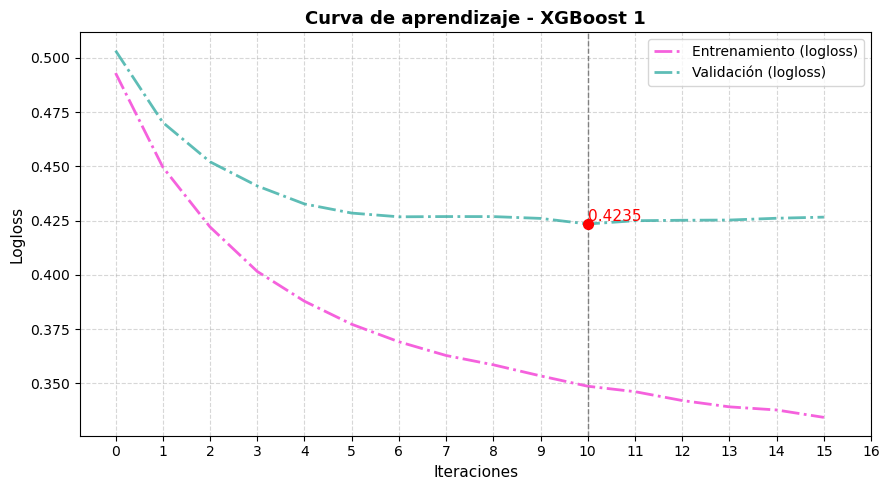

Mejor iteración: 9, logloss de validación: 0.4177


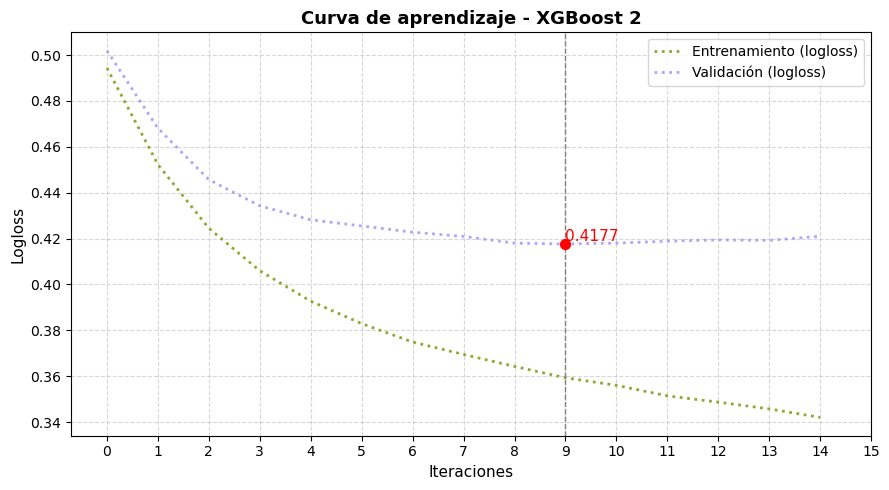

Mejor iteración: 14, logloss de validación: 0.4735


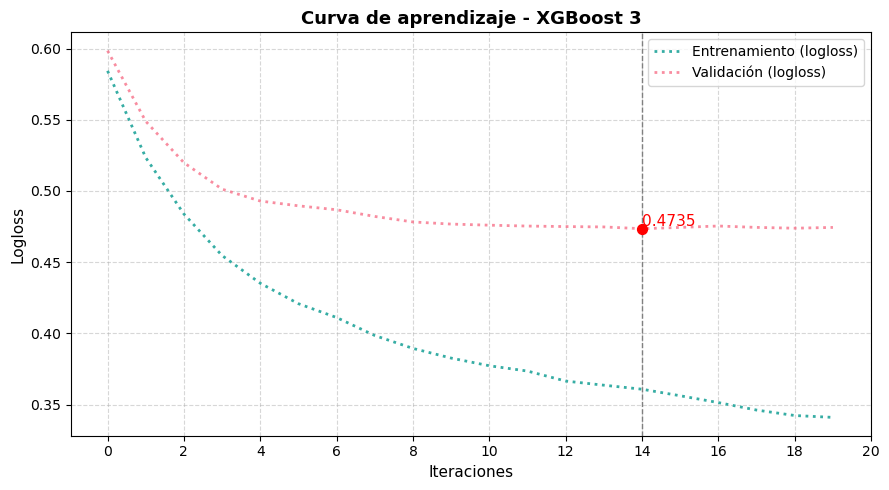

Mejor iteración: 21, logloss de validación: 0.4797


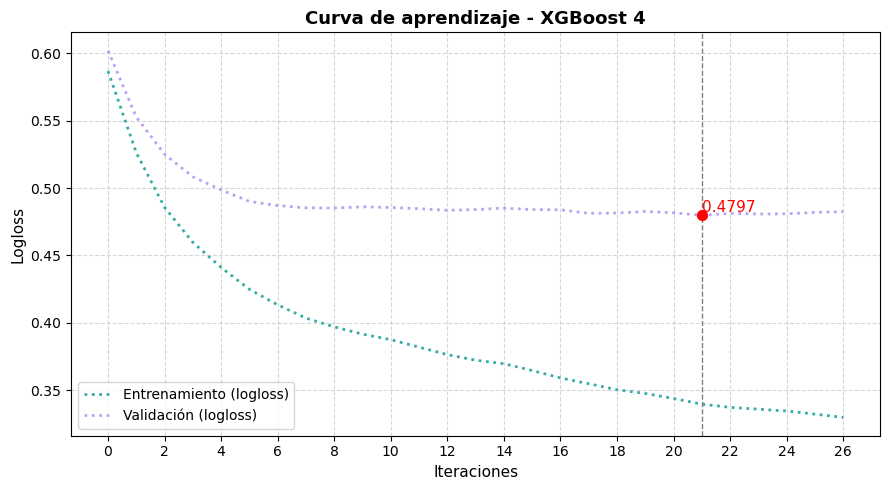

In [43]:
# Graficar las curvas de aprendizaje para los cuatro modelos XGBoost
for i in range(1, 5):
    modelo = globals()[f"modelo_xgb_{i}"]
    resultados_eval = globals()[f"resultados_eval_{i}"]
    
    # Generar curva de aprendizaje con estilo único para cada modelo
    graficar_curva_aprendizaje(
        modelo,
        resultados_eval,
        metrica='logloss',
        nombre_modelo=f"XGBoost {i}"
    )


Basado en la visualización de la curva de aprendizaje, podemos determinar el número óptimo de árboles para nuestro modelo utilizando la mejor iteración.
Por ejemplo, en el caso de XGBoost 1, la mejor iteración resultó ser la 10, con un logloss de validación de 0.4251.
Dado que las iteraciones comienzan en cero, el número total de árboles correspondiente a esa mejor iteración es 11 (mejor iteración + 1).
Esto indica que construir 11 árboles produce el menor logloss de validación y, por tanto, es el número óptimo de árboles para el modelo.

Sin embargo, el modelo muestra signos de sobreajuste (overfitting).
Para mitigar este problema, se pueden aplicar técnicas de ajuste de hiperparámetros (hyperparameter tuning) y validación cruzada (cross-validation).
Por ahora, el enfoque se centrará en comparar los modelos base.

Notas:

XGBoost 1: modelo entrenado en el dataset con ingeniería de características, sin PCA y sin balanceo.

XGBoost 2: modelo entrenado en el dataset con PCA y sin balanceo.

XGBoost 3: modelo entrenado en el dataset sin PCA, pero con balanceo aplicado (SMOTENC).

XGBoost 4: modelo entrenado en el dataset con PCA y con balanceo aplicado (SMOTENC).

In [44]:
# Realizar predicciones con el modelo XGBoost 1 (sin PCA ni balanceo)
y_pred_entren_1 = modelo_xgb_1.predict(X_entrenamiento_proc_1)
y_pred_prueba_1 = modelo_xgb_1.predict(X_prueba_proc_1)

# Mostrar los resultados de clasificación
print(f"{'='*30} XGBoost (Ingeniería de características 1 - Sin PCA) {'='*30}")
print("Reporte de clasificación (Conjunto de Entrenamiento):")
print(classification_report(y_entrenamiento, y_pred_entren_1))

print("Reporte de clasificación (Conjunto de Prueba):")
print(classification_report(y_prueba, y_pred_prueba_1))

============================== XGBoost (Ingeniería de características 1 - Sin PCA) ==============================
Reporte de clasificación (Conjunto de Entrenamiento):
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4139
           1       0.74      0.58      0.65      1495

    accuracy                           0.83      5634
   macro avg       0.80      0.75      0.77      5634
weighted avg       0.83      0.83      0.83      5634

Reporte de clasificación (Conjunto de Prueba):
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [45]:
# Realizar predicciones con el modelo XGBoost 2 (con PCA)
y_pred_entren_2 = modelo_xgb_2.predict(X_entrenamiento_proc_2)
y_pred_prueba_2 = modelo_xgb_2.predict(X_prueba_proc_2)

# Mostrar los reportes de clasificación
print(f"{'='*30} XGBoost (Ingeniería de características 2 - Con PCA) {'='*30}")
print("Reporte de clasificación (Conjunto de Entrenamiento):")
print(classification_report(y_entrenamiento, y_pred_entren_2))

print("Reporte de clasificación (Conjunto de Prueba):")
print(classification_report(y_prueba, y_pred_prueba_2))

============================== XGBoost (Ingeniería de características 2 - Con PCA) ==============================
Reporte de clasificación (Conjunto de Entrenamiento):
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4139
           1       0.73      0.58      0.65      1495

    accuracy                           0.83      5634
   macro avg       0.80      0.75      0.77      5634
weighted avg       0.83      0.83      0.83      5634

Reporte de clasificación (Conjunto de Prueba):
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [46]:
# Realizar predicciones con el modelo XGBoost 3 (datos balanceados con SMOTENC, sin PCA)
y_pred_entren_3 = modelo_xgb_3.predict(X_entrenamiento_res_1)
y_pred_prueba_3 = modelo_xgb_3.predict(X_prueba_proc_1)

# Mostrar los reportes de clasificación
print(f"{'='*30} XGBoost (Ingeniería de características 3 - Balanceado sin PCA) {'='*30}")
print("Reporte de clasificación (Conjunto de Entrenamiento):")
print(classification_report(y_entrenamiento_res_1, y_pred_entren_3))

print("Reporte de clasificación (Conjunto de Prueba):")
print(classification_report(y_prueba, y_pred_prueba_3))

============================== XGBoost (Ingeniería de características 3 - Balanceado sin PCA) ==============================
Reporte de clasificación (Conjunto de Entrenamiento):
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      4139
           1       0.82      0.89      0.85      4139

    accuracy                           0.85      8278
   macro avg       0.85      0.85      0.85      8278
weighted avg       0.85      0.85      0.85      8278

Reporte de clasificación (Conjunto de Prueba):
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.54      0.72      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409



In [47]:
# Realizar predicciones con el modelo XGBoost 4 (balanceado con PCA)
y_pred_entren_4 = modelo_xgb_4.predict(X_entrenamiento_res_2)
y_pred_prueba_4 = modelo_xgb_4.predict(X_prueba_proc_2)

# Mostrar los reportes de clasificación
print(f"{'='*30} XGBoost (Ingeniería de características 4 - Balanceado con PCA) {'='*30}")
print("Reporte de clasificación (Conjunto de Entrenamiento):")
print(classification_report(y_entrenamiento_res_2, y_pred_entren_4))

print("Reporte de clasificación (Conjunto de Prueba):")
print(classification_report(y_prueba, y_pred_prueba_4))


============================== XGBoost (Ingeniería de características 4 - Balanceado con PCA) ==============================
Reporte de clasificación (Conjunto de Entrenamiento):
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      4139
           1       0.83      0.91      0.87      4139

    accuracy                           0.86      8278
   macro avg       0.86      0.86      0.86      8278
weighted avg       0.86      0.86      0.86      8278

Reporte de clasificación (Conjunto de Prueba):
              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1035
           1       0.53      0.73      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409



<table style="border-collapse: collapse; text-align: center;">
  <tr style="background-color:#003366; color:white;">
    <th>Métrica (Test)</th>
    <th>XGBoost FE1<br>Sin PCA</th>
    <th>XGBoost FE2<br>Con PCA</th>
    <th>XGBoost FE3<br>Balanceado Sin PCA</th>
    <th>XGBoost FE4<br>Balanceado Con PCA</th>
  </tr>
  <tr>
    <td><b>Precision</b></td>
    <td>0.62</td>
    <td style="background-color:#c6efce;">0.65</td>
    <td>0.54</td>
    <td>0.53</td>
  </tr>
  <tr>
    <td><b>Recall</b></td>
    <td>0.57</td>
    <td>0.49</td>
    <td style="background-color:#c6efce;">0.72</td>
    <td style="background-color:#c6efce;">0.73</td>
  </tr>
  <tr>
    <td><b>F1-Score</b></td>
    <td style="background-color:#c6efce;">0.60</td>
    <td>0.56</td>
    <td style="background-color:#c6efce;">0.62</td>
    <td>0.61</td>
  </tr>
  <tr>
    <td><b>Accuracy</b></td>
    <td>0.79</td>
    <td style="background-color:#c6efce;">0.80</td>
    <td>0.76</td>
    <td>0.76</td>
  </tr>
  <tr>
    <td><b>Overall (Weighted)</b></td>
    <td>0.623</td>
    <td>0.594</td>
    <td style="background-color:#c6efce;">0.656</td>
    <td style="background-color:#c6efce;">0.655</td>
  </tr>
</table>


**Analisis de resultados**

- Precision: el mejor fue FE2 (con PCA) → predice con menos falsos positivos.

- Recall: destacan FE3 y FE4 (ambos balanceados), ideales si lo importante es **detectar churners**.

- Accuracy: mejor en FE2, pero el recall es bajo.

- Overall: gana FE3 (seguido por FE4) → mejor equilibrio general, ideal para producción.

# Registrar en ML flow los experimentos

import mlflow, mlflow.xgboost
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

EXPERIMENT = "Proyecto-Tablero-Prod"
mlflow.set_experiment(EXPERIMENT)

def _metrics(y_tr, ytr_pred, y_te, yte_pred):
    m = {
        "precision_train": precision_score(y_tr, ytr_pred, zero_division=0),
        "recall_train":    recall_score(y_tr, ytr_pred, zero_division=0),
        "f1_train":        f1_score(y_tr, ytr_pred, zero_division=0),
        "accuracy_train":  accuracy_score(y_tr, ytr_pred),

        "precision_test": precision_score(y_te, yte_pred, zero_division=0),
        "recall_test":    recall_score(y_te, yte_pred, zero_division=0),
        "f1_test":        f1_score(y_te, yte_pred, zero_division=0),
        "accuracy_test":  accuracy_score(y_te, yte_pred)
    }
    m["overall_test"] = 0.35*m["recall_test"] + 0.25*m["f1_test"] + 0.25*m["precision_test"] + 0.15*m["accuracy_test"]
    return m

def _log_cm(y_true, y_pred, title, fname):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    plt.imshow(cm); plt.title(title); plt.colorbar()
    for (i,j), v in np.ndenumerate(cm):
        color = "white" if v > cm.max()/2 else "black"
        plt.text(j, i, str(v), ha="center", va="center", color=color)
    plt.xlabel("Predicho"); plt.ylabel("Real")
    mlflow.log_figure(fig, fname); plt.close(fig)

def log_xgb_run(nombre, model, resultados_eval, y_tr, ytr_pred, y_te, yte_pred, data_tag):
    with mlflow.start_run(run_name=f"XGB_{nombre}"):
        # === params EXACTOS de tu notebook ===
        mlflow.log_params({
            "objective": "binary:logistic",
            "learning_rate": 0.3,
            "n_estimators_requested": 300,
            "eval_metric": "logloss",
            "random_state": 42
        })
        # árboles efectivos por early stopping
        if hasattr(model, "best_iteration") and model.best_iteration is not None:
            mlflow.log_param("n_estimators_effective", int(model.best_iteration)+1)

        mlflow.set_tags({
            "model_type": "xgboost",
            "feature_engineering": nombre,
            **data_tag
        })

        # === métricas (mismo .predict que usaste) ===
        m = _metrics(y_tr, ytr_pred, y_te, yte_pred)
        mlflow.log_metrics(m)

        # === curva de aprendizaje (logloss train/valid) ===
        if resultados_eval and "validation_0" in resultados_eval and "validation_1" in resultados_eval:
            train_ll = resultados_eval["validation_0"]["logloss"]
            valid_ll = resultados_eval["validation_1"]["logloss"]
            fig = plt.figure()
            plt.plot(train_ll, label="train_logloss")
            plt.plot(valid_ll, label="valid_logloss")
            if hasattr(model, "best_iteration") and model.best_iteration is not None:
                bi = model.best_iteration
                plt.axvline(bi, color="gray", linestyle="--"); 
            plt.legend(); plt.title(f"Learning curve - {nombre}")
            plt.xlabel("iter"); plt.ylabel("logloss")
            mlflow.log_figure(fig, f"learning_curve_{nombre}.png"); plt.close(fig)

        # === matriz de confusión (test) ===
        _log_cm(y_te, yte_pred, f"CM - {nombre}", f"cm_{nombre}.png")

        # === guarda el modelo XGBoost ===
        mlflow.xgboost.log_model(model, artifact_path="model")

# FE1
log_xgb_run(
    "FE1_sin_PCA", modelo_xgb_1, resultados_eval_1,
    y_entrenamiento, y_pred_entren_1, y_prueba, y_pred_prueba_1,
    data_tag={"pca": False, "smote": False}
)

# FE2
log_xgb_run(
    "FE2_con_PCA", modelo_xgb_2, resultados_eval_2,
    y_entrenamiento, y_pred_entren_2, y_prueba, y_pred_prueba_2,
    data_tag={"pca": True, "smote": False}
)

# FE3 (SMOTE sin PCA)
log_xgb_run(
    "FE3_balanceado_sin_PCA", modelo_xgb_3, resultados_eval_3,
    y_entrenamiento_res_1, y_pred_entren_3, y_prueba, y_pred_prueba_3,
    data_tag={"pca": False, "smote": True}
)

# FE4 (SMOTE con PCA)
log_xgb_run(
    "FE4_balanceado_con_PCA", modelo_xgb_4, resultados_eval_4,
    y_entrenamiento_res_2, y_pred_entren_4, y_prueba, y_pred_prueba_4,
    data_tag={"pca": True, "smote": True}
)

print("Listo. Abre: mlflow ui --port 5000")


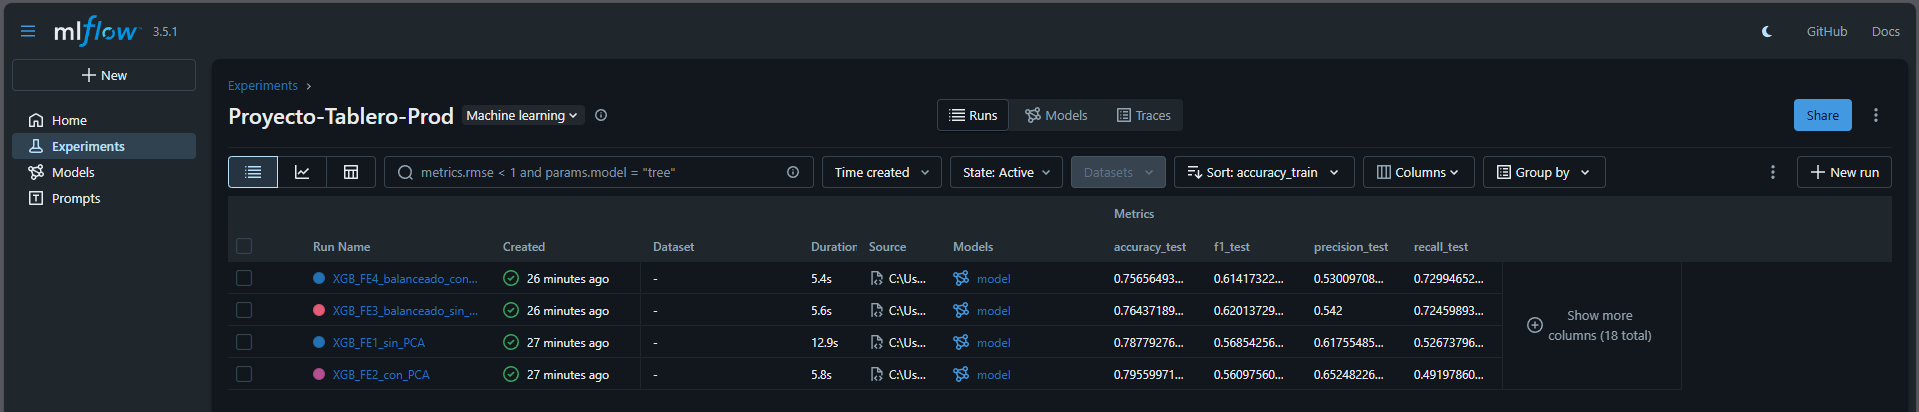

# Ajuste de recall usando el umbral e hiperparametros

## Decisión de negocio — Priorizar Recall sobre Precisión

Dado que el objetivo principal del modelo es identificar la mayor cantidad posible de clientes propensos a desertar (churn), se decidió priorizar la métrica de recall por encima de la precisión. En este contexto, un falso positivo (un cliente que el modelo clasifica como propenso a abandonar, aunque no lo haga) no representa una pérdida significativa, ya que simplemente recibiría una acción preventiva del área de retención. En cambio, un falso negativo (un cliente que realmente abandona y no fue identificado) implica una pérdida directa para la empresa. Por lo tanto, el modelo fue ajustado para maximizar el recall, aceptando una menor precisión como compromiso estratégico, ya que el costo de intervenir a un cliente que finalmente no se va es considerablemente menor que el de perder un cliente que sí abandona.


========================== FE4_pca_smote ==========================
Umbral aplicado: 0.150 | scale_pos_weight: 1.00

>> Classification Report — TRAIN
              precision    recall  f1-score   support

No churn (0)       0.97      0.46      0.62      4139
   Churn (1)       0.64      0.98      0.78      4139

    accuracy                           0.72      8278
   macro avg       0.80      0.72      0.70      8278
weighted avg       0.80      0.72      0.70      8278

>> Classification Report — TEST
              precision    recall  f1-score   support

No churn (0)       0.97      0.45      0.62      1035
   Churn (1)       0.39      0.96      0.55       374

    accuracy                           0.59      1409
   macro avg       0.68      0.70      0.58      1409
weighted avg       0.81      0.59      0.60      1409



,Precision,Recall,F1-Score,Accuracy
Train,0.643693,0.983813,0.778213,0.719618
Test,0.387027,0.957219,0.551193,0.586231


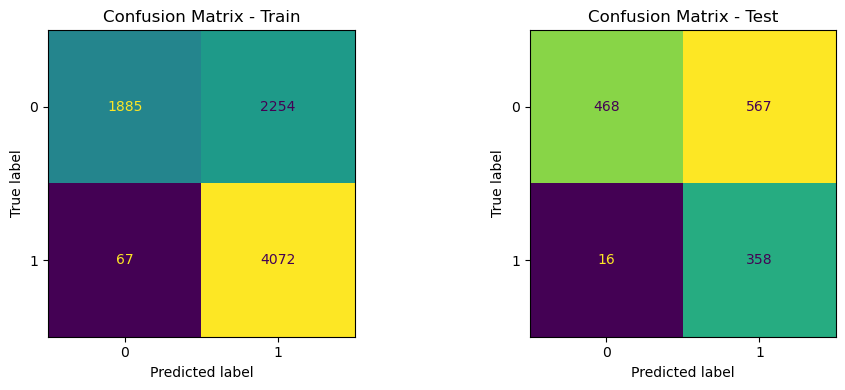


========================== FE3_no_pca_smote ==========================
Umbral aplicado: 0.150 | scale_pos_weight: 1.00

>> Classification Report — TRAIN
              precision    recall  f1-score   support

No churn (0)       0.96      0.44      0.60      4139
   Churn (1)       0.63      0.98      0.77      4139

    accuracy                           0.71      8278
   macro avg       0.80      0.71      0.68      8278
weighted avg       0.80      0.71      0.68      8278

>> Classification Report — TEST
              precision    recall  f1-score   support

No churn (0)       0.97      0.43      0.60      1035
   Churn (1)       0.38      0.97      0.54       374

    accuracy                           0.57      1409
   macro avg       0.68      0.70      0.57      1409
weighted avg       0.81      0.57      0.58      1409



,Precision,Recall,F1-Score,Accuracy
Train,0.634745,0.981638,0.770968,0.708384
Test,0.379202,0.965241,0.544495,0.571327


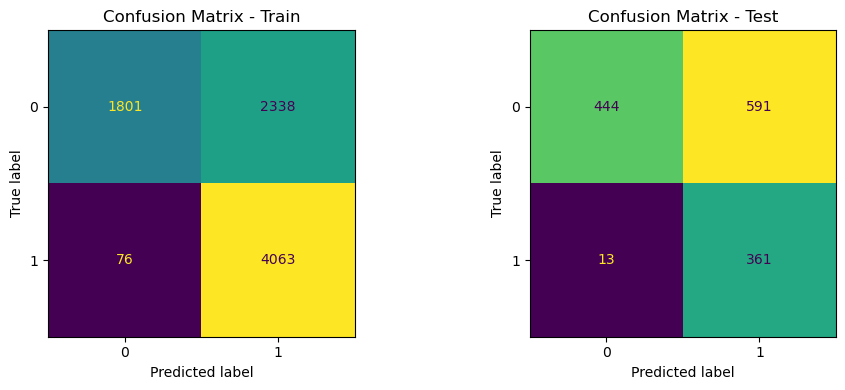


========================== FE1_no_pca ==========================
Umbral aplicado: 0.550 | scale_pos_weight: 2.77

>> Classification Report — TRAIN
              precision    recall  f1-score   support

No churn (0)       0.91      0.78      0.84      4139
   Churn (1)       0.56      0.79      0.66      1495

    accuracy                           0.78      5634
   macro avg       0.74      0.79      0.75      5634
weighted avg       0.82      0.78      0.79      5634

>> Classification Report — TEST
              precision    recall  f1-score   support

No churn (0)       0.90      0.76      0.82      1035
   Churn (1)       0.54      0.76      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



,Precision,Recall,F1-Score,Accuracy
Train,0.564017,0.792642,0.659066,0.782393
Test,0.535849,0.759358,0.628319,0.761533


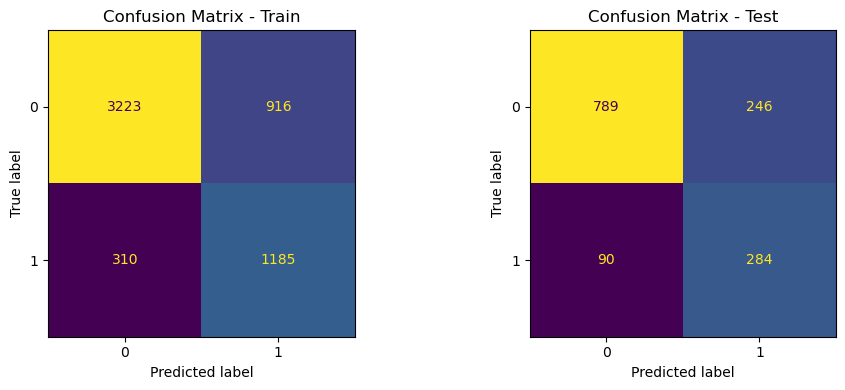


========================== FE2_pca ==========================
Umbral aplicado: 0.550 | scale_pos_weight: 2.77

>> Classification Report — TRAIN
              precision    recall  f1-score   support

No churn (0)       0.91      0.79      0.85      4139
   Churn (1)       0.58      0.79      0.67      1495

    accuracy                           0.79      5634
   macro avg       0.74      0.79      0.76      5634
weighted avg       0.82      0.79      0.80      5634

>> Classification Report — TEST
              precision    recall  f1-score   support

No churn (0)       0.90      0.76      0.82      1035
   Churn (1)       0.54      0.76      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



,Precision,Recall,F1-Score,Accuracy
Train,0.578171,0.786622,0.666478,0.791090
Test,0.535985,0.756684,0.627494,0.761533


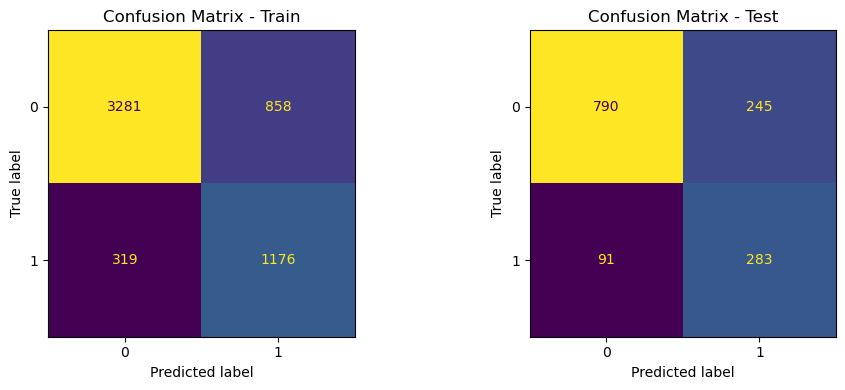


=== TOP por Recall (Test) ===


,scenario,threshold,precision_test,recall_test,f1_test,accuracy_test,overall_test
3,FE4_pca_smote,0.15,0.392157,0.962567,0.557276,0.594038,0.663362
2,FE3_no_pca_smote,0.15,0.380700,0.959893,0.545178,0.574876,0.653664
0,FE1_no_pca,0.55,0.538175,0.772727,0.634468,0.763662,0.678165
1,FE2_pca,0.55,0.533582,0.764706,0.628571,0.760114,0.672202


In [50]:
# ==== IMPORTS ====
import os, random, numpy as np, pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             roc_auc_score, average_precision_score,
                             classification_report, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# ==== CONFIG ====
SEED = 42
MIN_PRECISION = 0.55   # piso de precisión exigido al elegir umbral (puedes ajustarlo)
TRIALS = 15            # número de combinaciones aleatorias para tuning (sube si quieres)
rng = random.Random(SEED); np.random.seed(SEED)

# Escenarios/tipos de dataset que ya tienes en carpetas
SCENARIOS = [
    ("FE1_no_pca",       "data/processed/no_pca"),
    ("FE2_pca",          "data/processed/pca"),
    ("FE3_no_pca_smote", "data/processed/no_pca_smote"),
    ("FE4_pca_smote",    "data/processed/pca_smote"),
]
TARGET = "Churn"
SC_MAP = dict(SCENARIOS)

# ==== UTILIDADES ====
def load_split(folder):
    """Carga X_train, y_train, X_test, y_test desde la carpeta dada."""
    Xtr = pd.read_csv(os.path.join(folder, "X_train.csv"))
    ytr = pd.read_csv(os.path.join(folder, "y_train.csv"))[TARGET].astype(int)
    Xte = pd.read_csv(os.path.join(folder, "X_test.csv"))
    yte = pd.read_csv(os.path.join(folder, "y_test.csv"))[TARGET].astype(int)
    return Xtr, ytr, Xte, yte

def pick_threshold(y_val, p_val, min_precision=0.55):
    """Barre umbrales y elige el que maximiza recall cumpliendo un piso de precisión."""
    candidates = np.linspace(0.15, 0.85, 29)
    best = (0.5, -1, -1)  # (thr, recall, precision)
    for thr in candidates:
        yhat = (p_val >= thr).astype(int)
        pr = precision_score(y_val, yhat, zero_division=0)
        rc = recall_score(y_val, yhat, zero_division=0)
        if pr >= min_precision and rc > best[1]:
            best = (thr, rc, pr)
    if best[1] < 0:  # si nadie cumplió el piso de precisión, toma el mayor recall
        for thr in candidates:
            yhat = (p_val >= thr).astype(int)
            pr = precision_score(y_val, yhat, zero_division=0)
            rc = recall_score(y_val, yhat, zero_division=0)
            if rc > best[1]:
                best = (thr, rc, pr)
    return best  # (threshold, recall_val, precision_val)

def metric_row(name, threshold, params, spw, yte, p_te, yhat_te):
    """Arma el registro de métricas para un escenario."""
    out = dict(
        scenario=name, threshold=float(threshold), scale_pos_weight=float(spw), **params,
        precision_test=precision_score(yte, yhat_te, zero_division=0),
        recall_test=recall_score(yte,  yhat_te, zero_division=0),
        f1_test=f1_score(yte,         yhat_te, zero_division=0),
        accuracy_test=accuracy_score(yte, yhat_te),
        roc_auc_test=roc_auc_score(yte, p_te),
        pr_auc_test=average_precision_score(yte, p_te),
    )
    out["overall_test"] = (
        0.35*out["recall_test"] + 0.25*out["f1_test"] +
        0.25*out["precision_test"] + 0.15*out["accuracy_test"]
    )
    return out

def _metric_table(y_tr, yhat_tr, y_te, yhat_te):
    def m(y, yhat):
        return {
            "Precision": precision_score(y, yhat, zero_division=0),
            "Recall":    recall_score(y, yhat, zero_division=0),
            "F1-Score":  f1_score(y, yhat, zero_division=0),
            "Accuracy":  accuracy_score(y, yhat),
        }
    return pd.DataFrame({"Train": m(y_tr, yhat_tr), "Test": m(y_te, yhat_te)}).T

# ==== BASELINE (mismos hiperparámetros del notebook) ====
def run_baseline_for(name, folder, min_precision=MIN_PRECISION):
    Xtr, ytr, Xte, yte = load_split(folder)
    # split interno SOLO para seleccionar umbral (no tocamos el TEST)
    Xtr_i, Xval, ytr_i, yval = train_test_split(Xtr, ytr, test_size=0.2, stratify=ytr, random_state=SEED)
    params = dict(objective="binary:logistic", learning_rate=0.3, n_estimators=300,
                  random_state=SEED, eval_metric="logloss", n_jobs=-1)
    clf = XGBClassifier(**params)
    clf.fit(Xtr_i, ytr_i)
    p_val = clf.predict_proba(Xval)[:,1]
    thr, _, _ = pick_threshold(yval, p_val, min_precision=min_precision)
    # evaluar en TEST
    p_te = clf.predict_proba(Xte)[:,1]
    yhat_te = (p_te >= thr).astype(int)
    return metric_row(name, thr, params, spw=1.0, yte=yte, p_te=p_te, yhat_te=yhat_te)

baseline_rows = [run_baseline_for(nm, fldr) for nm, fldr in SCENARIOS]
baseline_df = pd.DataFrame(baseline_rows).sort_values("recall_test", ascending=False)

# ==== TUNING MANUAL (priorizando RECALL) ====
GRID = {
    "n_estimators":     [200, 350, 500],
    "max_depth":        [3, 4, 5],
    "learning_rate":    [0.03, 0.06, 0.1],
    "subsample":        [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "reg_lambda":       [1.0, 2.0],
    "gamma":            [0, 0.5, 1.0],
}
def sample_params(): return {k: rng.choice(v) for k, v in GRID.items()}

def tune_for_recall(name, folder, trials=TRIALS, min_precision=MIN_PRECISION):
    Xtr, ytr, Xte, yte = load_split(folder)
    # split interno SOLO para umbral
    Xtr_i, Xval, ytr_i, yval = train_test_split(Xtr, ytr, test_size=0.2, stratify=ytr, random_state=SEED)
    # si el set es SMOTE, peso=1; si no, compensa desbalance
    is_smote = "smote" in name.lower()
    pos = ytr_i.sum(); neg = len(ytr_i) - pos
    spw = 1.0 if is_smote else max(1.0, neg / max(1, pos))

    best = None
    for _ in range(trials):
        params = sample_params()
        clf = XGBClassifier(objective="binary:logistic", eval_metric="aucpr",
                            random_state=SEED, n_jobs=-1, scale_pos_weight=spw, **params)
        clf.fit(Xtr_i, ytr_i)
        # umbral por validación
        p_val = clf.predict_proba(Xval)[:,1]
        thr, _, _ = pick_threshold(yval, p_val, min_precision=min_precision)
        # métricas test
        p_te = clf.predict_proba(Xte)[:,1]
        yhat_te = (p_te >= thr).astype(int)
        row = metric_row(name, thr, params, spw, yte, p_te, yhat_te)
        if (best is None) or (row["recall_test"] > best["recall_test"]):
            best = row
    return best

tuned_rows = [tune_for_recall(nm, fldr) for nm, fldr in SCENARIOS]
tuned_df = pd.DataFrame(tuned_rows).sort_values("recall_test", ascending=False)

# === Elige qué tabla usar para los reportes (cambia a baseline_df si quieres los baseline) ===
df_final = tuned_df   # <--- cambia a baseline_df si quieres ver los baseline

# ==== REPORTES DETALLADOS: clasificación + tablas + matrices de confusión ====
def report_for_scenario(row):
    name   = row["scenario"]
    folder = SC_MAP[name]
    thr    = float(row["threshold"])
    spw    = float(row["scale_pos_weight"])
    hp_keys = ["n_estimators","max_depth","learning_rate","subsample",
               "colsample_bytree","min_child_weight","reg_lambda","gamma"]
    params = {k: row[k] for k in hp_keys if k in row}

    Xtr, ytr, Xte, yte = load_split(folder)
    clf = XGBClassifier(objective="binary:logistic", eval_metric="aucpr",
                        random_state=SEED, n_jobs=-1, scale_pos_weight=spw, **params)
    clf.fit(Xtr, ytr)

    p_tr, p_te = clf.predict_proba(Xtr)[:,1], clf.predict_proba(Xte)[:,1]
    yhat_tr, yhat_te = (p_tr >= thr).astype(int), (p_te >= thr).astype(int)

    print(f"\n{'='*26} {name} {'='*26}")
    print(f"Umbral aplicado: {thr:.3f} | scale_pos_weight: {spw:.2f}")
    print("\n>> Classification Report — TRAIN")
    print(classification_report(ytr, yhat_tr, target_names=["No churn (0)","Churn (1)"]))
    print(">> Classification Report — TEST")
    print(classification_report(yte, yhat_te, target_names=["No churn (0)","Churn (1)"]))

    display(_metric_table(ytr, yhat_tr, yte, yhat_te))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ConfusionMatrixDisplay.from_predictions(ytr, yhat_tr, ax=axes[0], colorbar=False)
    axes[0].set_title("Confusion Matrix - Train")
    ConfusionMatrixDisplay.from_predictions(yte, yhat_te, ax=axes[1], colorbar=False)
    axes[1].set_title("Confusion Matrix - Test")
    plt.tight_layout(); plt.show()

# Ejecuta reportes para cada mejor escenario (según df_final)
for _, row in df_final.iterrows():
    report_for_scenario(row)

# Vista rápida de ranking (por recall_test)
print("\n=== TOP por Recall (Test) ===")
display(df_final[["scenario","threshold","precision_test","recall_test","f1_test","accuracy_test","overall_test"]]
        .sort_values("recall_test", ascending=False))



========================== FE2_pca ==========================
Umbral aplicado: 0.150 | scale_pos_weight: 2.77

>> Classification Report — TRAIN
              precision    recall  f1-score   support

No churn (0)       0.99      0.41      0.58      4139
   Churn (1)       0.38      0.99      0.54      1495

    accuracy                           0.56      5634
   macro avg       0.68      0.70      0.56      5634
weighted avg       0.83      0.56      0.57      5634

>> Classification Report — TEST
              precision    recall  f1-score   support

No churn (0)       0.98      0.40      0.57      1035
   Churn (1)       0.37      0.97      0.54       374

    accuracy                           0.55      1409
   macro avg       0.67      0.69      0.55      1409
weighted avg       0.82      0.55      0.56      1409



,Precision,Recall,F1-Score,Accuracy
Train,0.375446,0.985953,0.543811,0.561058
Test,0.370295,0.973262,0.536478,0.553584


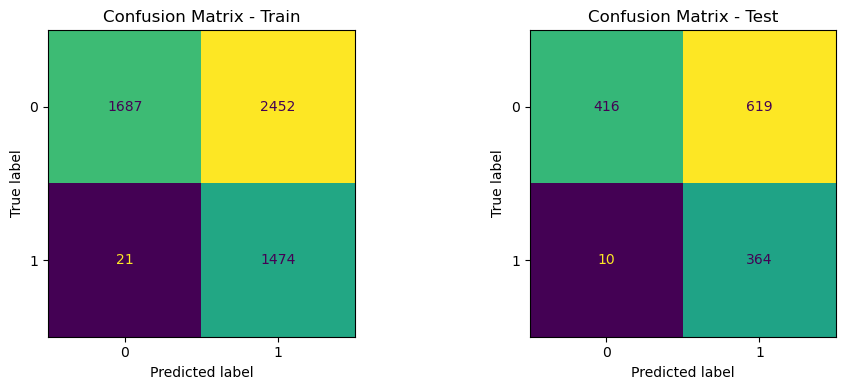


========================== FE1_no_pca ==========================
Umbral aplicado: 0.150 | scale_pos_weight: 2.77

>> Classification Report — TRAIN
              precision    recall  f1-score   support

No churn (0)       0.99      0.43      0.60      4139
   Churn (1)       0.39      0.99      0.56      1495

    accuracy                           0.58      5634
   macro avg       0.69      0.71      0.58      5634
weighted avg       0.83      0.58      0.59      5634

>> Classification Report — TEST
              precision    recall  f1-score   support

No churn (0)       0.96      0.43      0.59      1035
   Churn (1)       0.38      0.95      0.54       374

    accuracy                           0.57      1409
   macro avg       0.67      0.69      0.57      1409
weighted avg       0.80      0.57      0.58      1409



,Precision,Recall,F1-Score,Accuracy
Train,0.387712,0.991973,0.557519,0.582180
Test,0.375264,0.949198,0.537879,0.567069


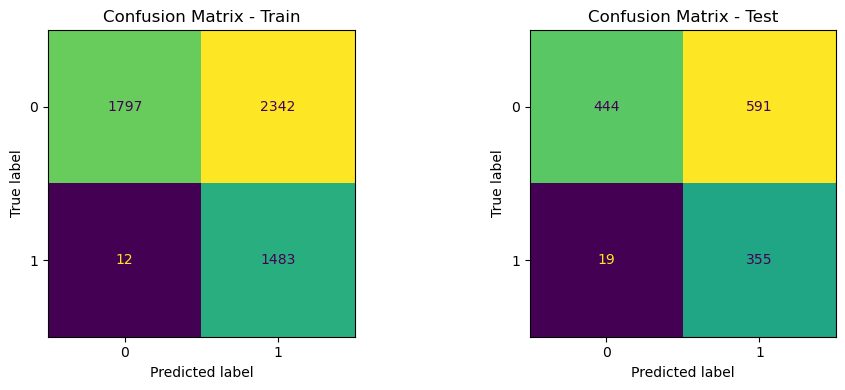


========================== FE4_pca_smote ==========================
Umbral aplicado: 0.400 | scale_pos_weight: 1.00

>> Classification Report — TRAIN
              precision    recall  f1-score   support

No churn (0)       0.93      0.75      0.83      4139
   Churn (1)       0.79      0.94      0.86      4139

    accuracy                           0.84      8278
   macro avg       0.86      0.84      0.84      8278
weighted avg       0.86      0.84      0.84      8278

>> Classification Report — TEST
              precision    recall  f1-score   support

No churn (0)       0.91      0.70      0.79      1035
   Churn (1)       0.50      0.81      0.62       374

    accuracy                           0.73      1409
   macro avg       0.70      0.76      0.71      1409
weighted avg       0.80      0.73      0.75      1409



,Precision,Recall,F1-Score,Accuracy
Train,0.787290,0.939841,0.856828,0.842957
Test,0.497537,0.810160,0.616480,0.732434


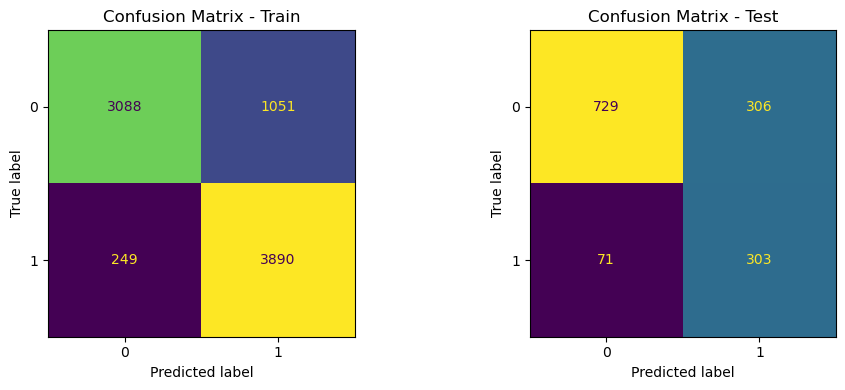


========================== FE3_no_pca_smote ==========================
Umbral aplicado: 0.450 | scale_pos_weight: 1.00

>> Classification Report — TRAIN
              precision    recall  f1-score   support

No churn (0)       0.86      0.72      0.78      4139
   Churn (1)       0.76      0.88      0.81      4139

    accuracy                           0.80      8278
   macro avg       0.81      0.80      0.80      8278
weighted avg       0.81      0.80      0.80      8278

>> Classification Report — TEST
              precision    recall  f1-score   support

No churn (0)       0.91      0.70      0.79      1035
   Churn (1)       0.50      0.82      0.62       374

    accuracy                           0.73      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.73      0.75      1409



,Precision,Recall,F1-Score,Accuracy
Train,0.755713,0.878956,0.812688,0.797415
Test,0.498366,0.815508,0.618661,0.733144


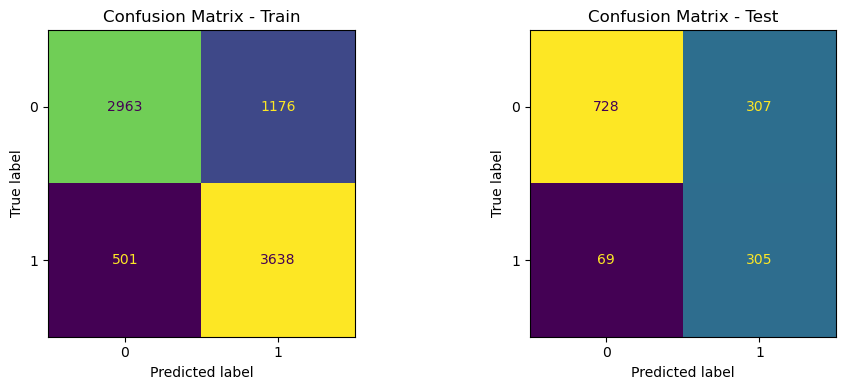


=== TOP por Recall (Test) ===


,scenario,threshold,precision_test,recall_test,f1_test,accuracy_test,overall_test
1,FE2_pca,0.15,0.379167,0.973262,0.545727,0.569908,0.657351
0,FE1_no_pca,0.15,0.377637,0.957219,0.541604,0.569908,0.650323
3,FE4_pca_smote,0.40,0.492868,0.831551,0.618905,0.728176,0.678213
2,FE3_no_pca_smote,0.45,0.495987,0.826203,0.619860,0.731015,0.677785


In [61]:
# ==== IMPORTS ====
import os, random, numpy as np, pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             roc_auc_score, average_precision_score,
                             classification_report, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# ==== CONFIG ====
SEED = 42
MIN_PRECISION = 0.75   # piso de precisión exigido al elegir umbral (puedes ajustarlo)
TRIALS = 15            # número de combinaciones aleatorias para tuning (sube si quieres)
rng = random.Random(SEED); np.random.seed(SEED)

# Escenarios/tipos de dataset que ya tienes en carpetas
SCENARIOS = [
    ("FE1_no_pca",       "data/processed/no_pca"),
    ("FE2_pca",          "data/processed/pca"),
    ("FE3_no_pca_smote", "data/processed/no_pca_smote"),
    ("FE4_pca_smote",    "data/processed/pca_smote"),
]
TARGET = "Churn"
SC_MAP = dict(SCENARIOS)

# ==== UTILIDADES ====
def load_split(folder):
    """Carga X_train, y_train, X_test, y_test desde la carpeta dada."""
    Xtr = pd.read_csv(os.path.join(folder, "X_train.csv"))
    ytr = pd.read_csv(os.path.join(folder, "y_train.csv"))[TARGET].astype(int)
    Xte = pd.read_csv(os.path.join(folder, "X_test.csv"))
    yte = pd.read_csv(os.path.join(folder, "y_test.csv"))[TARGET].astype(int)
    return Xtr, ytr, Xte, yte

def pick_threshold(y_val, p_val, min_precision=0.55):
    """Barre umbrales y elige el que maximiza recall cumpliendo un piso de precisión."""
    candidates = np.linspace(0.15, 0.85, 29)
    best = (0.5, -1, -1)  # (thr, recall, precision)
    for thr in candidates:
        yhat = (p_val >= thr).astype(int)
        pr = precision_score(y_val, yhat, zero_division=0)
        rc = recall_score(y_val, yhat, zero_division=0)
        if pr >= min_precision and rc > best[1]:
            best = (thr, rc, pr)
    if best[1] < 0:  # si nadie cumplió el piso de precisión, toma el mayor recall
        for thr in candidates:
            yhat = (p_val >= thr).astype(int)
            pr = precision_score(y_val, yhat, zero_division=0)
            rc = recall_score(y_val, yhat, zero_division=0)
            if rc > best[1]:
                best = (thr, rc, pr)
    return best  # (threshold, recall_val, precision_val)

def metric_row(name, threshold, params, spw, yte, p_te, yhat_te):
    """Arma el registro de métricas para un escenario."""
    out = dict(
        scenario=name, threshold=float(threshold), scale_pos_weight=float(spw), **params,
        precision_test=precision_score(yte, yhat_te, zero_division=0),
        recall_test=recall_score(yte,  yhat_te, zero_division=0),
        f1_test=f1_score(yte,         yhat_te, zero_division=0),
        accuracy_test=accuracy_score(yte, yhat_te),
        roc_auc_test=roc_auc_score(yte, p_te),
        pr_auc_test=average_precision_score(yte, p_te),
    )
    out["overall_test"] = (
        0.35*out["recall_test"] + 0.25*out["f1_test"] +
        0.25*out["precision_test"] + 0.15*out["accuracy_test"]
    )
    return out

def _metric_table(y_tr, yhat_tr, y_te, yhat_te):
    def m(y, yhat):
        return {
            "Precision": precision_score(y, yhat, zero_division=0),
            "Recall":    recall_score(y, yhat, zero_division=0),
            "F1-Score":  f1_score(y, yhat, zero_division=0),
            "Accuracy":  accuracy_score(y, yhat),
        }
    return pd.DataFrame({"Train": m(y_tr, yhat_tr), "Test": m(y_te, yhat_te)}).T

# ==== BASELINE (mismos hiperparámetros del notebook) ====
def run_baseline_for(name, folder, min_precision=MIN_PRECISION):
    Xtr, ytr, Xte, yte = load_split(folder)
    # split interno SOLO para seleccionar umbral (no tocamos el TEST)
    Xtr_i, Xval, ytr_i, yval = train_test_split(Xtr, ytr, test_size=0.2, stratify=ytr, random_state=SEED)
    params = dict(objective="binary:logistic", learning_rate=0.3, n_estimators=300,
                  random_state=SEED, eval_metric="logloss", n_jobs=-1)
    clf = XGBClassifier(**params)
    clf.fit(Xtr_i, ytr_i)
    p_val = clf.predict_proba(Xval)[:,1]
    thr, _, _ = pick_threshold(yval, p_val, min_precision=min_precision)
    # evaluar en TEST
    p_te = clf.predict_proba(Xte)[:,1]
    yhat_te = (p_te >= thr).astype(int)
    return metric_row(name, thr, params, spw=1.0, yte=yte, p_te=p_te, yhat_te=yhat_te)

baseline_rows = [run_baseline_for(nm, fldr) for nm, fldr in SCENARIOS]
baseline_df = pd.DataFrame(baseline_rows).sort_values("recall_test", ascending=False)

# ==== TUNING MANUAL (priorizando RECALL) ====
GRID = {
    "n_estimators":     [200, 350, 500],
    "max_depth":        [3, 4, 5],
    "learning_rate":    [0.03, 0.06, 0.1],
    "subsample":        [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "reg_lambda":       [1.0, 2.0],
    "gamma":            [0, 0.5, 1.0],
}
def sample_params(): return {k: rng.choice(v) for k, v in GRID.items()}

def tune_for_recall(name, folder, trials=TRIALS, min_precision=MIN_PRECISION):
    Xtr, ytr, Xte, yte = load_split(folder)
    # split interno SOLO para umbral
    Xtr_i, Xval, ytr_i, yval = train_test_split(Xtr, ytr, test_size=0.2, stratify=ytr, random_state=SEED)
    # si el set es SMOTE, peso=1; si no, compensa desbalance
    is_smote = "smote" in name.lower()
    pos = ytr_i.sum(); neg = len(ytr_i) - pos
    spw = 1.0 if is_smote else max(1.0, neg / max(1, pos))

    best = None
    for _ in range(trials):
        params = sample_params()
        clf = XGBClassifier(objective="binary:logistic", eval_metric="aucpr",
                            random_state=SEED, n_jobs=-1, scale_pos_weight=spw, **params)
        clf.fit(Xtr_i, ytr_i)
        # umbral por validación
        p_val = clf.predict_proba(Xval)[:,1]
        thr, _, _ = pick_threshold(yval, p_val, min_precision=min_precision)
        # métricas test
        p_te = clf.predict_proba(Xte)[:,1]
        yhat_te = (p_te >= thr).astype(int)
        row = metric_row(name, thr, params, spw, yte, p_te, yhat_te)
        if (best is None) or (row["recall_test"] > best["recall_test"]):
            best = row
    return best

tuned_rows = [tune_for_recall(nm, fldr) for nm, fldr in SCENARIOS]
tuned_df = pd.DataFrame(tuned_rows).sort_values("recall_test", ascending=False)

# === Elige qué tabla usar para los reportes (cambia a baseline_df si quieres los baseline) ===
df_final = tuned_df   # <--- cambia a baseline_df si quieres ver los baseline

# ==== REPORTES DETALLADOS: clasificación + tablas + matrices de confusión ====
def report_for_scenario(row):
    name   = row["scenario"]
    folder = SC_MAP[name]
    thr    = float(row["threshold"])
    spw    = float(row["scale_pos_weight"])
    hp_keys = ["n_estimators","max_depth","learning_rate","subsample",
               "colsample_bytree","min_child_weight","reg_lambda","gamma"]
    params = {k: row[k] for k in hp_keys if k in row}

    Xtr, ytr, Xte, yte = load_split(folder)
    clf = XGBClassifier(objective="binary:logistic", eval_metric="aucpr",
                        random_state=SEED, n_jobs=-1, scale_pos_weight=spw, **params)
    clf.fit(Xtr, ytr)

    p_tr, p_te = clf.predict_proba(Xtr)[:,1], clf.predict_proba(Xte)[:,1]
    yhat_tr, yhat_te = (p_tr >= thr).astype(int), (p_te >= thr).astype(int)

    print(f"\n{'='*26} {name} {'='*26}")
    print(f"Umbral aplicado: {thr:.3f} | scale_pos_weight: {spw:.2f}")
    print("\n>> Classification Report — TRAIN")
    print(classification_report(ytr, yhat_tr, target_names=["No churn (0)","Churn (1)"]))
    print(">> Classification Report — TEST")
    print(classification_report(yte, yhat_te, target_names=["No churn (0)","Churn (1)"]))

    display(_metric_table(ytr, yhat_tr, yte, yhat_te))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ConfusionMatrixDisplay.from_predictions(ytr, yhat_tr, ax=axes[0], colorbar=False)
    axes[0].set_title("Confusion Matrix - Train")
    ConfusionMatrixDisplay.from_predictions(yte, yhat_te, ax=axes[1], colorbar=False)
    axes[1].set_title("Confusion Matrix - Test")
    plt.tight_layout(); plt.show()

# Ejecuta reportes para cada mejor escenario (según df_final)
for _, row in df_final.iterrows():
    report_for_scenario(row)

# Vista rápida de ranking (por recall_test)
print("\n=== TOP por Recall (Test) ===")
display(df_final[["scenario","threshold","precision_test","recall_test","f1_test","accuracy_test","overall_test"]]
        .sort_values("recall_test", ascending=False))


# Guardar experimentos en MLflow con el ajuste de hiperparametros balanceadndo recall

In [62]:
import mlflow, mlflow.xgboost
from mlflow.models.signature import infer_signature

# Tracking local
mlflow.set_tracking_uri("file:mlruns")
mlflow.set_experiment("seleccion_de_hiperparametros")

import json
from sklearn.metrics import ConfusionMatrixDisplay

def _log_conf_mats_fig(y_tr, yhat_tr, y_te, yhat_te, title_prefix=""):
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    ConfusionMatrixDisplay.from_predictions(y_tr, yhat_tr, ax=axes[0], colorbar=False)
    axes[0].set_title(f"{title_prefix}Confusion Matrix - Train")
    ConfusionMatrixDisplay.from_predictions(y_te, yhat_te, ax=axes[1], colorbar=False)
    axes[1].set_title(f"{title_prefix}Confusion Matrix - Test")
    plt.tight_layout()
    return fig

def _log_scalar_metrics_from_row(row_dict: dict):
    for k in ["precision_test","recall_test","f1_test","accuracy_test",
              "roc_auc_test","pr_auc_test","overall_test"]:
        if k in row_dict:
            mlflow.log_metric(k, float(row_dict[k]))

# --- Guarda cada fila de df_final como un run ---
hp_keys = ["n_estimators","max_depth","learning_rate","subsample",
           "colsample_bytree","min_child_weight","reg_lambda","gamma"]

run_ids = []
for _, row in df_final.iterrows():
    name   = row["scenario"]
    folder = SC_MAP[name]
    thr    = float(row["threshold"])
    spw    = float(row["scale_pos_weight"])
    params = {k: row[k] for k in hp_keys if k in row}

    # Reproducimos EXACTO el entrenamiento de tu 'report_for_scenario'
    Xtr, ytr, Xte, yte = load_split(folder)
    clf = XGBClassifier(objective="binary:logistic", eval_metric="aucpr",
                        random_state=SEED, n_jobs=-1, scale_pos_weight=spw, **params)
    clf.fit(Xtr, ytr)
    p_tr, p_te = clf.predict_proba(Xtr)[:,1], clf.predict_proba(Xte)[:,1]
    yhat_tr, yhat_te = (p_tr >= thr).astype(int), (p_te >= thr).astype(int)

    with mlflow.start_run(run_name=f"XGB | {name} | seleccion_hp"):
        # Tags y parámetros
        mlflow.set_tags({"model":"xgboost", "fase":"seleccion_hp", "scenario":name})
        mlflow.log_param("threshold", thr)
        mlflow.log_param("scale_pos_weight", spw)
        mlflow.log_params(params)

        # Métricas: EXACTAMENTE las que ya calculaste en df_final
        _log_scalar_metrics_from_row(row.to_dict())

        # Reportes de texto (mismo formato que imprimes)
        rep_tr = classification_report(ytr, yhat_tr, target_names=["No churn (0)","Churn (1)"])
        rep_te = classification_report(yte, yhat_te, target_names=["No churn (0)","Churn (1)"])
        mlflow.log_text(rep_tr, f"{name}_classification_report_train.txt")
        mlflow.log_text(rep_te, f"{name}_classification_report_test.txt")

        # Matrices de confusión: idénticas a las que muestra tu celda
        fig = _log_conf_mats_fig(ytr, yhat_tr, yte, yhat_te, title_prefix=f"{name} - ")
        mlflow.log_figure(fig, f"{name}_confusion_matrices.png")
        plt.close(fig)

        # (Opcional) Guarda el umbral para inferencia futura
        mlflow.log_text(json.dumps({"threshold": thr}, indent=2), f"{name}_inference_threshold.json")

        # (Opcional) Firma + log del modelo como artefacto (no cambia métricas)
        signature = infer_signature(Xtr, clf.predict_proba(Xtr)[:,1])
        mlflow.xgboost.log_model(clf, artifact_path="model", signature=signature, input_example=Xtr.head(5))

        run_ids.append(mlflow.active_run().info.run_id)

# Guarda también el ranking completo (por si quieres verlo en MLflow)
try:
    mlflow.log_table(df_final, "ranking_df_final.csv")  # si tu versión no soporta, usa to_csv+log_artifact
except Exception:
    tmp_path = "ranking_df_final.csv"
    df_final.to_csv(tmp_path, index=False)
    mlflow.log_artifact(tmp_path)

print("Runs guardados en MLflow:", run_ids)
print("Experimento:", mlflow.get_experiment_by_name("seleccion_de_hiperparametros").name)


2025/11/07 11:47:10 INFO mlflow.tracking.fluent: Experiment with name 'seleccion_de_hiperparametros' does not exist. Creating a new experiment.
2025/11/07 11:47:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/11/07 11:47:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/11/07 11:47:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/11/07 11:47:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Runs guardados en MLflow: ['31d226c1908643078a270b0f7cbd0784', 'bb8df2ef3a3845e58545e4b649ff1fb6', 'f6eaa00edacb4e34ad695ac9ce1a6a8c', 'f8e7e62eced44dd98508caab61eba20f']
Experimento: seleccion_de_hiperparametros


# Empaquetamiento del modelo

In [67]:
# === Guardar SOLO el mejor modelo en MLflow (con umbral incluido) ===
import mlflow, mlflow.pyfunc, mlflow.xgboost
from mlflow.models.signature import infer_signature
from xgboost import XGBClassifier
import pandas as pd, json

# 0) Config MLflow (usa el mismo experimento que ya vienes usando)
EXPERIMENT = "Proyecto-Tablero-Prod"
mlflow.set_experiment(EXPERIMENT)

# 1) Tomar el mejor de tu df_final (cambia a 'recall_test' si prefieres)
SORT_BY = "overall_test"   # o "recall_test"
best = df_final.sort_values(SORT_BY, ascending=False).iloc[0]
name   = best["scenario"]
thr    = float(best["threshold"])
spw    = float(best["scale_pos_weight"])
hp_keys = ["n_estimators","max_depth","learning_rate","subsample",
           "colsample_bytree","min_child_weight","reg_lambda","gamma"]
params = {k: best[k] for k in hp_keys if k in best}

# 2) Reentrenar EXACTO como en tu report_for_scenario
Xtr, ytr, Xte, yte = load_split(SC_MAP[name])
clf_best = XGBClassifier(
    objective="binary:logistic", eval_metric="aucpr",
    random_state=SEED, n_jobs=-1, scale_pos_weight=spw, **params
)
clf_best.fit(Xtr, ytr)

# 3) Empaquetar como PyFunc con el UMBRAL dentro (listo para servir o FastAPI)
class XGBWithThreshold(mlflow.pyfunc.PythonModel):
    def __init__(self, booster, threshold: float):
        self.model = booster
        self.threshold = threshold
    def predict(self, context, model_input: pd.DataFrame):
        proba = self.model.predict_proba(model_input)[:,1]
        label = (proba >= self.threshold).astype(int)
        return pd.DataFrame({"proba": proba, "label": label})

sig = infer_signature(Xtr, clf_best.predict_proba(Xtr)[:,1])

if mlflow.active_run() is not None:
    print("Cerrando run activo:", mlflow.active_run().info.run_id)
    mlflow.end_run()

with mlflow.start_run(run_name=f"BEST | {name} | pyfunc_threshold"):
    mlflow.set_tags({"model":"xgboost", "scenario":name, "best_by":SORT_BY})
    mlflow.log_params({"threshold": thr, "scale_pos_weight": spw, **params})
    mlflow.pyfunc.log_model(
        artifact_path="model",
        python_model=XGBWithThreshold(clf_best, thr),
        input_example=Xtr.head(5),
        signature=sig
    )
    mlflow.log_text(json.dumps({"threshold": thr}, indent=2), "inference_threshold.json")
    RUN_ID = mlflow.active_run().info.run_id

print("Guardado en MLflow")
print("RUN_ID:", RUN_ID)
print("Escenario:", name, "| Umbral:", thr, "| HP:", params)


2025/11/07 13:15:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 13:15:10 INFO mlflow.pyfunc: Validating input example against model signature


Cerrando run activo: 73400ce32a404c358e69f50f2e2c4107


Guardado en MLflow
RUN_ID: c043b2ed1d1f43f5be7fbc704a7b54b7
Escenario: FE4_pca_smote | Umbral: 0.39999999999999997 | HP: {'n_estimators': np.int64(200), 'max_depth': np.int64(5), 'learning_rate': np.float64(0.06), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.8), 'min_child_weight': np.int64(5), 'reg_lambda': np.float64(2.0), 'gamma': np.float64(0.5)}
